## Load Packages

In [17]:
# Data handling
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import networkx as nx
import collections
import random
import datetime

# Natural language processing
from nltk import word_tokenize
import nltk, re, pprint
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.probability import FreqDist
from afinn import Afinn

# Plotting
from wordcloud import WordCloud
from wordcloud import get_single_color_func
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
from fa2 import ForceAtlas2
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm
import matplotlib.dates as mdates
from PIL import Image
import imageio

import os
path=os.getcwd()

## Table of Content

* [Motivation](#0-bullet)

* [Data Cleaning and Preprocessing](#1-bullet)
    
* [The Politicians Network](#2-bullet)

* [Basic Statistics](#3-bullet)

   * [Full Graph](#4-bullet)
    
   * [Giant Connected Component](#5-bullet)

   * [Most Connected Politicians](#6-bullet)
   
   * [Age Distribution Across Different Parties](#7-bullet)

* [Tools, Theory and Analysis](#8-bullet)

    * [TFIDF Word Clouds](#9-bullet)
    
        * [Parties](#10-bullet)

        * [Wing](#11-bullet)

        * [Prime Ministers](#12-bullet)

        * [Twitter Word Clouds](#13-bullet)

    * [Sentiment Analysis](#14-bullet)
    
        * [Wikipedia](#15-bullet)

        * [Twitter](#16-bullet)

        * [Sentiment Scores Over Time](#17-bullet)
    
    * [COVID-19 Simulation](#18-bullet)
    
        * [Centrality](#19-bullet)

        * [Simulating Pandemic](#20-bullet)
        
        * [Ensemble Graphs](#21-bullet)
* [Discussion](#22-bullet)
* [Contribution](#23-bullet)
      
    
    
    
    
   
  
 
    
   

# Introduction & Motivation <a class="anchor" id="0-bullet"></a>

The Danish politicians have an important influence on the everyday life of the citizens of Denmark, especially in the current times of the COVID-19 pandemic, where new restrictions are issued on a weekly basis. On the other hand, the citizens of Denmark also have power over the politicians in terms of their voting power. It is important for the politicians that they have good media coverage and reputation to be reelected. To analyze the reputation of the politicians, tweets mentioning Danish politicians are analyzed. The goal of this project is to create a website where the end user can gain insight into how politicians are covered on Wikipedia compared to Twitter. This insight will include the words associated with the politicians and the tone used when writing about the politicians. Additionally, the transmission of COVID-19 is of interest. During this COVID-19 pandemic everyone is advised not to gather in big groups by the politicians, but how fast does COVID-19 actually spread among a group? This will be analyzed by simulating that a politician in the Danish politican network is infected by COVID-19. 

Four different datasets are used in this project. The first dataset is a list of all current and former Danish politicians. The data was scraped from the website [danskepolitikere.dk](https://www.danskepolitikere.dk/oversigt/danske-politikere) and contains information about which party the politicians belong to and whether they are in the Danish parliament, EU parliament or neither. The website was last updated in 2015, which means that politicians might have left their listed parties in the mean time. The politicians' names were used to guess their gender using the [Gender guesser library](https://pypi.org/project/gender-guesser/), which was added as an attribute to the dataset. 

The second dataset consist of the Wikipedia pages for all the Danish politicians, who have Wikipedia pages and are in the first dataset. The information from the Wikipedia pages were used to extract a politicians' ages and the links to other politicians' Wikipedia pages. These links represent edges in the network in this project. 

The third dataset is a list of the names of Danish politicians with a Twitter account and their Twitter account name. This list was scraped from the website [twitterpolitikere.dk](https://filip.journet.sdu.dk/twitter/politikere/). 

The last dataset consists of all the tweets written between November 16th and December 2nd, where politicians with a Twitter account are mentioned or tagged. All four datasets are merged into one big data frame in order to model and analyze the network in this project.

These datasets were chosen to understand the reputation of politicians in the Danish population. These datasets also make it possible to compare the language used about the politicians on Wikipedia, which is a neutral informative webpage compared to Twitter, which is a social media page where everyone can share their opinion freely. 

# Data Cleaning and Preprocessing <a class="anchor" id="1-bullet"></a>

The full dataframe used for this project includes Wikipedia and Twitter data. 

The full names of politicians, their respective parties and their parliament memberships were scraped from the webpage [danskepolitikere.dk](https://www.danskepolitikere.dk/oversigt/danske-politikere). The layout of the the website was perfect for the purpose, since all the wanted information was stored in the *title* tag in the HTML. `BeautifulSoup` and `re` (regex) was used to extract the HTML and the title tags within the HTML soup, which ended up with a list of 585 politicians' names, parties and parliament membership.

Afterwards, the Wikipedia text was downloaded using the Wikipedia API and the full names of the politicians. The first download ensured that the majority of Wikipedia pages were obtained, but a large part were missing. This was due to an obvious mishap, which was almost impossible to get around. Some Wikipedia page links for certain politicians did not include their middle name. This became a problem since it was not simply possible to remove all middle names as some politicians share the same first name and surname. Also, some politicians have the same name as other people with a Wikipedia page. In this case the initial download of the Wikipedia pages resulted in several redirection pages that are used to navigate the user to the right Wikipedia page. Another function was created to combat this issue and make sure that the redirection page or non-politician Wikipedia webpage was not downloaded. From the downloaded Wikipedia texts, the politicians' ages and the links to other Danish politicians' Wikipedia pages were saved using regex. Using a `gender-guesser` package in Python, the gender attribute was added to the dataframe. 

The Twitter data, which includes tweet date and tweet text, was downloaded using the Twitter API with `Tweepy`. Twitter only allows downloading of tweets that are up to a week old. Therefore the Twitter data was downloaded two times to have data for approximately two weeks. To download the Twitter data, an application for a Twitter developer account was created, since Twitter needs to approve an account before access to the data is granted. The `Tweepy` package came in handy when downloading the Twitter data. To download Twitter data for Danish politicians, the names of the politicians with their Twitter name was scraped from the website [twitterpolitikere.dk](https://filip.journet.sdu.dk/twitter/politikere/). On the website, the politicians are not named by their full name. This meant, that the names had to be altered again in order to merge the tweets with the dataframe containing the Wikipedia data. 

Text analysis in this project primarily includes the creation of word clouds and sentiment analysis. To do text analysis of the Wikpedia and Twitter text, all parentheses, symbols, hashtags and emojis were removed using regex. Furthermore, all letters were changed to lower case and endings and stop words were removed.

# The Politicians Network <a class="anchor" id="2-bullet"></a>

Before jumping into the basic statistics the network is visualized in four different ways in order to better understand how the network is shaped and connected. As mentioned earlier, the nodes in the network are Danish politicians and the edges represent Wikipedia links. All visualizations are created using the library `ForceAtlas2` and `NetworkX`, and several functions are created to shorten the code.

In [2]:
# Load the graph and the dataframe containing all relevant information
G = nx.read_graphml("politicians.graphml")
politicians=pd.read_excel('politicians3.xlsx')
#Convert G to an undirected graph
Gu = G.to_undirected()
# Giant Component
GCC_nodes = max(nx.weakly_connected_components(G), key=len)
GCC = nx.subgraph(G, GCC_nodes)
# Undirected Giant Component
GCCu = GCC.to_undirected()

In [17]:
# The force atlas algorithm parameters will obtain the visualization we like
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

In [15]:
# Mapping color
def calc_graph_attributes(graph,colors,color_attribute,dict_key):
    
    #Calc colors for nodes 
    node_colors = []
    for num,value in enumerate(color_attribute):
        for node in graph.nodes.data():
            if node[1][dict_key] ==value :
                node_colors.append(colors[num])
                
    #Mapping size
    node_size = [(val+1)*8 for (node, val) in graph.degree()]
    
    
    #Find patches
    patches = [mpatches.Patch(color=colors[i], label= color_attribute[i]) for i in range(len(color_attribute))]
    
    #Find positions
    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=200)
             
    return node_colors,node_size,positions,patches

In [16]:
# Drawing Graph
def draw_graph(graph, node_colors, node_size, top_n, positions, patches, img_name):
    # Used for labelling
    freqs = FreqDist(dict(zip(list(graph.nodes()),node_size))).most_common(top_n)
    names = {names[0]: names[0] for names in freqs}
    
    #Show the visualisation
    plt.figure(figsize=(20,10))
    plt.legend(handles=patches, facecolor='white', fontsize=10,loc='upper left',bbox_to_anchor=(-0.1, 1, 0, 0))

    nx.draw_networkx_nodes(graph, positions, node_size=node_size, node_color=node_colors, alpha=1)
    nx.draw_networkx_labels(graph, positions, labels = names, font_size = 14)
    nx.draw_networkx_edges(graph, positions, edge_color="grey", alpha=0.25)
    plt.axis('off')
    plt.savefig(img_name)
    plt.show()
    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.60it/s]


BarnesHut Approximation  took  0.25  seconds
Repulsion forces  took  1.89  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


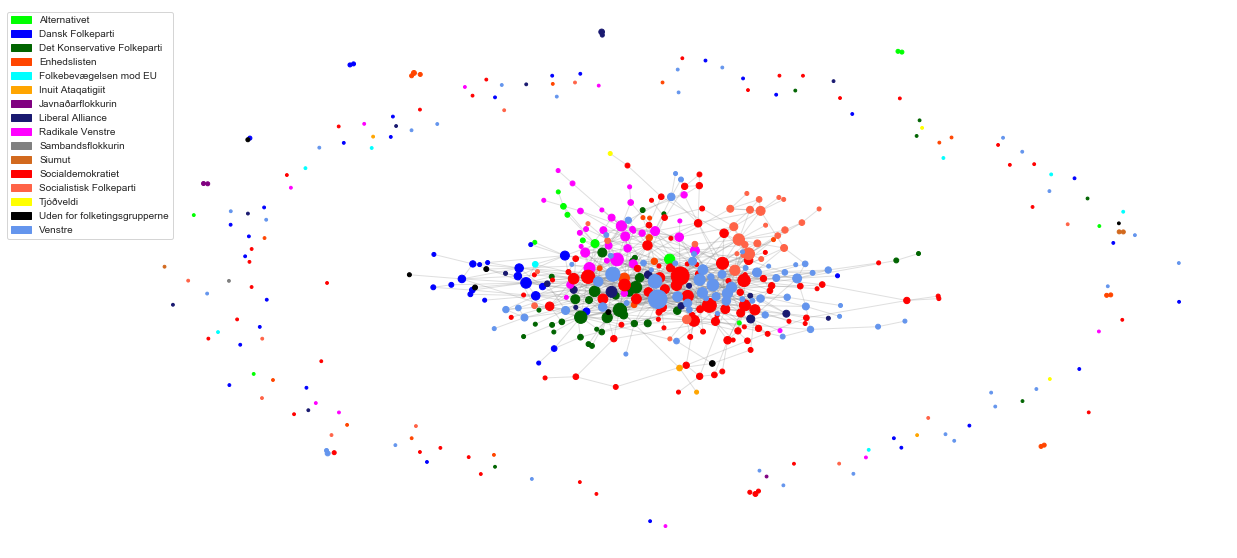

In [6]:
# Plotting entire network colored by party
parties = sorted(list(set(dict(Gu.nodes.data('Party')).values())))
colors = ['lime','blue','darkgreen','orangered','cyan','orange','purple','midnightblue','magenta','grey','chocolate'
          ,'red','tomato','yellow','black','cornflowerblue']
node_colors,node_size,positions,patches = calc_graph_attributes(Gu,colors,parties,'Party')
draw_graph(Gu, node_colors, node_size, 0, positions, patches,'Graph_images/Gu_party.png')

The graph above shows all nodes in the network colored according to their political party. The size of the nodes indicate, how connected the nodes are. The higher degree the larger node size. The network consist of one giant connected component in the middle of the plot and a large amount of small components in the outskirts of the plot. The small components will be left out for most of the analysis, as most of them are not connected to any other politicians. The giant connected component in the middle, shows how the two largest parties, Socialdemokraterne and Venstre, are in the middle surrounded by the smaller parties. In order to further examine the giant connected component a close-up can be seen below. 

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 182.13it/s]


BarnesHut Approximation  took  0.15  seconds
Repulsion forces  took  0.87  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


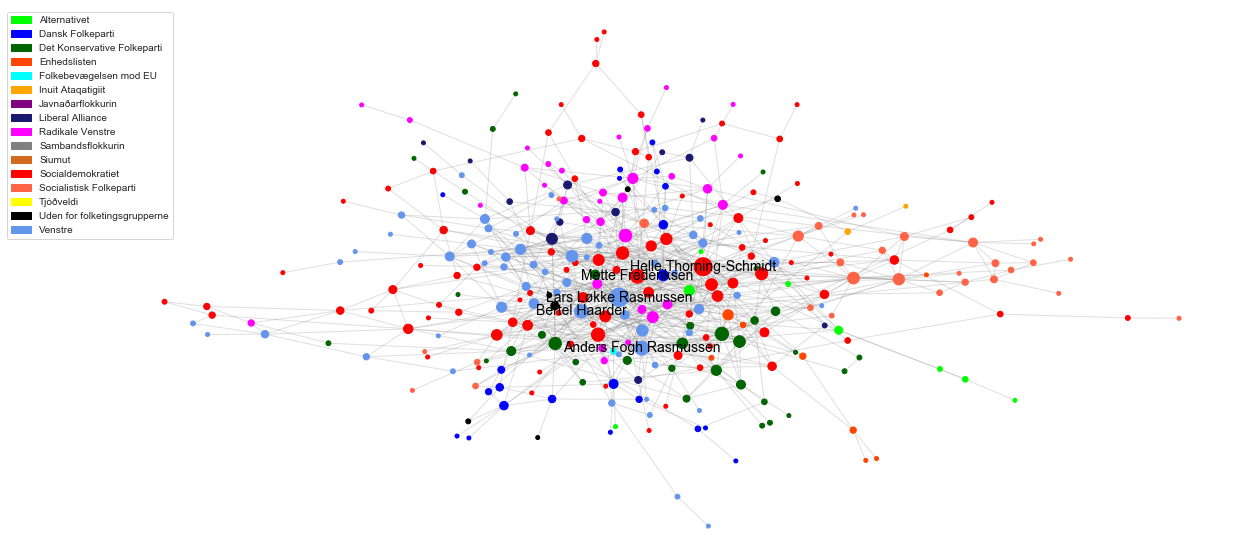

In [7]:
# Plotting only the GCC according to party
node_colors,node_size,positions,patches = calc_graph_attributes(GCCu,colors,parties,'Party')
draw_graph(GCCu, node_colors, node_size, 5, positions, patches,'Graph_images/GCC_party.png')

Generally, the most connected politicians are found in the middle. The names of the five most connected politicians can also been seen on the graph. Four of the five are current or former prime ministers and the last of the five, Bertel Haarder, is a well known minister. Besides having the two largest parties in the middle, smaller parties tend to gather in groups. Dansk Folkeparti and Det Konservative Folkeparti are mostly seen in the lower part of the graph, whereas Enhedslisten and Socialistisk Folkeparti are found top right. One of the attributes in the politician network is whether the politician is a part of the parliament. The Danish parliament consists of 179 members. The graph below shows which nodes are a part of the Danish parliament, the EU parliament or neither.

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 180.83it/s]


BarnesHut Approximation  took  0.13  seconds
Repulsion forces  took  0.89  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


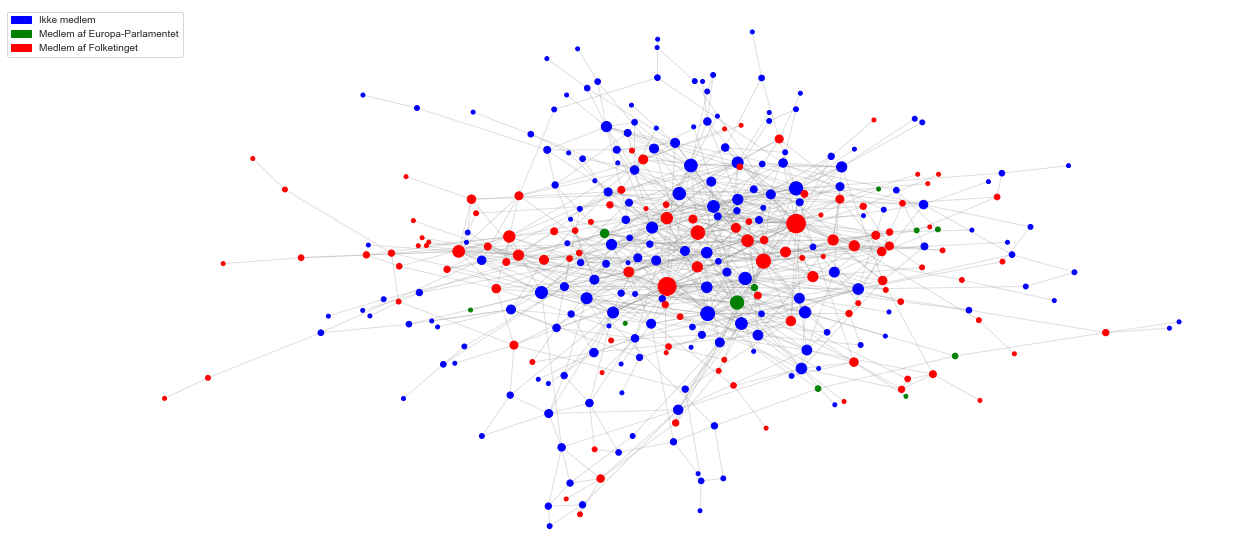

In [8]:
# Plotting GCC according to parliament membership
parliament = sorted(list(set(dict(Gu.nodes.data('Parliament')).values())))
colors = ['blue','green','red']
node_colors,node_size,positions,patches = calc_graph_attributes(GCCu,colors,parliament,'Parliament')
draw_graph(GCCu,node_colors,node_size, 0,positions,patches,'Graph_images/Gu_paliament.png')

Most of the politicians in the network are not a member of the Danish parliament, these are given in blue. The red nodes are a part of the Danish parliament, and the green nodes are a part of the European parliament. There seems to be no pattern regarding which politicians are in the parliaments. However, most of the highly connected politicians are in the Danish parlimaent.

The last graph visualizes the three political wings. The largest wings are red and blue, as these represent whether parties supports Socialdemokratiet (red) or Venstre (blue). The green wing is rather new and only consist of the party Alternativet. The politicians network visualized according to wing can be seen below. A few politicians are not a part of any wing indicating "No Blok".

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 160.36it/s]


BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  1.07  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


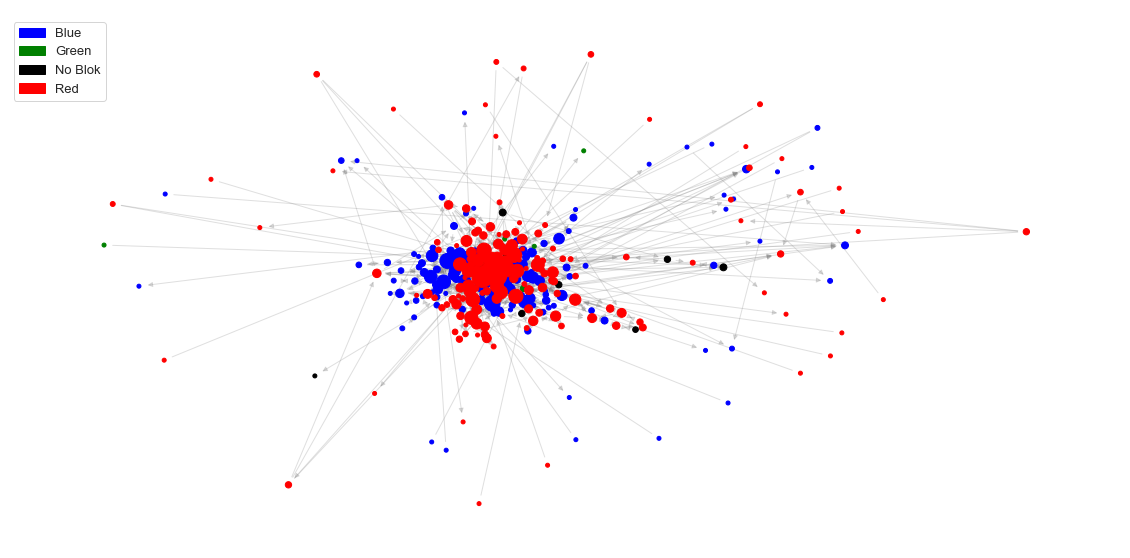

In [10]:
# Plotting graph according to political wing
blok = sorted(list(set(dict(Gu.nodes.data('Blok')).values())))
colors = ['blue','green','black','red']
node_colors,node_size,positions,patches = calc_graph_attributes(GCC,colors,blok,'Blok')
#Show the visualisation
plt.figure(figsize=(20,10))
plt.legend(handles=patches, facecolor='white', fontsize=13,loc='center left',bbox_to_anchor=(0, 0.9, 0, 0))

nx.draw_networkx_nodes(GCC, positions, node_size=node_size, node_color=node_colors, alpha=1)
nx.draw_networkx_edges(GCC, positions, edge_color="grey", alpha=0.25)
plt.axis('off')
plt.savefig('Graph_images/GCC_blok.png')
plt.show()

The middle part of the network is highly represented by the red wing, whereas the outer areas of the network is represented by the blue wing. Though, the wings seem to overlap, and politicians from different wings are also connected.

# Basic Statistics <a class="anchor" id="3-bullet"></a>

After all the visualisations, it is time to dig into the statistics. As mentioned earlier, all the necessary data and information is saved into one big dataframe. The first three rows of dataframe is shown below. For instance, the first politician, Uffe Elbæk, is a 66-year-old male member of the party Alternativet and the Danish parliament. The `pages` attribute includes Uffe Elbæk's entire Wikipedia coverage and `wordcount` shows the number of words used to describe him. The `LinksOut` attribute are all the references made to other politcians from his Wikipedia page. Likewise, the attribute `tweet` has Uffe Elbæk's tweet coverage.

This statistics section will start out by examining the entire network and then end up exploring the giant connected component.

In [10]:
politicians.head(3)

name         party             parliament  \
0      Uffe Elbæk  Alternativet  Medlem af Folketinget   
1  Josephine Fock  Alternativet            Ikke medlem   
2    Torsten Gejl  Alternativet  Medlem af Folketinget   

                                               pages  \
0  {{Infoboks leder \n|navn                 = Uff...   
1  {{Infoboks MF | billede = Josephine Fock.png|e...   
2  {{Infoboks MF |billede = Torsten Gejl.png }}\n...   

                                            LinksOut  wordcount   age  gender  \
0  ['Josephine Fock', 'Per Stig Møller', 'Mariann...       3284  66.0    male   
1                     ['Uffe Elbæk', 'Torsten Gejl']        680  55.0  female   
2                                 ['Josephine Fock']        234   NaN    male   

    blok                                              tweet  
0  Green  ['@DenGroenneStud @uffeelbaek Forureneren beta...  
1  Green                                                NaN  
2  Green  ['@taagf2019 @PHummelgaard @VictoriaRV @khoeng...

## Full Graph <a class="anchor" id="4-bullet"></a>

Firstly, the entire network is examined. The network consists of 477 politicians and 1013 edges. 425 of these edges are between different parties, whereas the rest are internal edges. The graph below show the in- and out-degree distribution of all politicians in the network.

In [11]:
# Number of nodes:
print("The politician network has", len(G), "nodes and", G.size(), "number of edges")

The politician network has 477 nodes and 1013 number of edges


In [12]:
# Edges between parties
# Creating variable to store sum
connectingLinks = 0

# Looping over the edge list of tuples
for fromNode, toNode in list(G.edges):
    # If the party of the first node is not equal to the node of the second, then add one to the sum
    if G.nodes[fromNode]['Party'] != G.nodes[toNode]['Party']:
        connectingLinks += 1
print(f"The politician network has {connectingLinks} edges between parties")

The politician network has 425 edges between parties


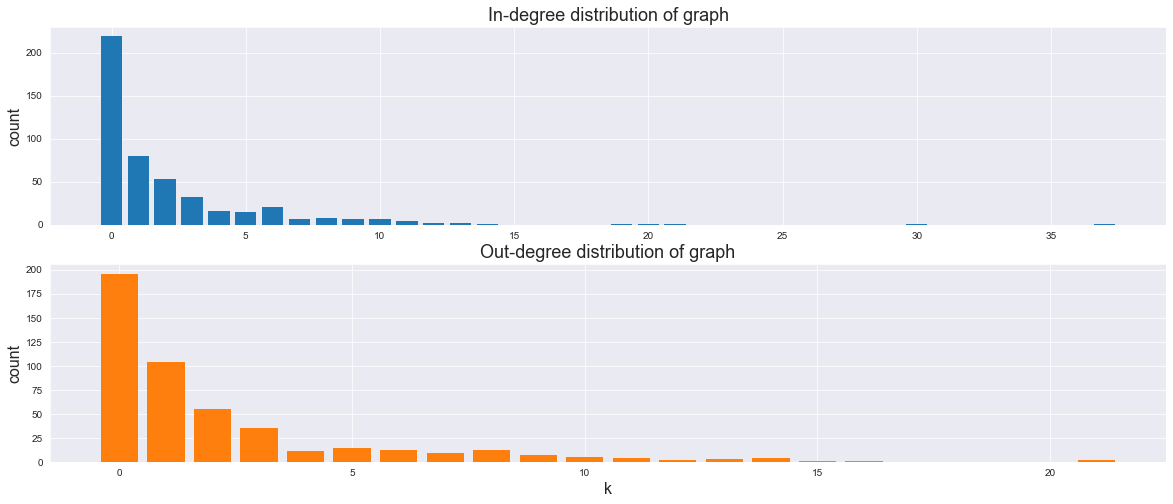

In [13]:
# In-degree distribution
degree_sequence = sorted([d for n, d in G.in_degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence)
bins, freq = zip(*degreeCount.items())

# Out-degree distribution
degree_sequence2 = sorted([d for n, d in G.out_degree()])  # degree sequence
degreeCount2 = collections.Counter(degree_sequence2)
bins2, freq2 = zip(*degreeCount2.items())

# Plotting distributions
fig, ax = plt.subplots(2,1, figsize=(20,8))
ax[0].bar(bins,freq, edgecolor="none")
ax[0].set_title('In-degree distribution of graph', fontsize=18)
ax[0].set_ylabel('count', fontsize=16)

ax[1].bar(bins2, freq2, edgecolor="none", color='#ff7f0e')
ax[1].set_title('Out-degree distribution of graph', fontsize=18)
ax[1].set_ylabel('count', fontsize=16)
ax[1].set_xlabel('k', fontsize = 16);

Both in and out-degree seem to follow a power-law distribution. Therefore, the network is said to be scale free according to [Chapter 5 in Network Science](http://networksciencebook.com/chapter/5#degree-dynamics). The probability of observing a high-degree node, also known as a hub, is larger for this type of network than in a random network. If hubs are present, a difference between the in-degree and out-degree will occur, since the hubs will connect large parts of the network, thus having a high in-degree.

**Compare with a random network**

It is of interest to compare the politicans network to a random network of same size and average degree to examine if there is a difference in the degree distribution. This is done by creating an Erdős–Rényi graph. The parameters for the random network are found using the formulas in [Chapter 3 in Network Science](http://networksciencebook.com/chapter/3#summary3). The degree distribution of the random network is seen further below.

In [14]:
# Calculating k, N and p of directed random network
avg_k = np.mean(list(dict(G.degree()).values()))
N = len(G.nodes())
p = avg_k/(N-1)

# Creating ER graph with the k, N and p found above
er = nx.erdos_renyi_graph(N, p, directed=True)

Text(0.5, 0, 'k')

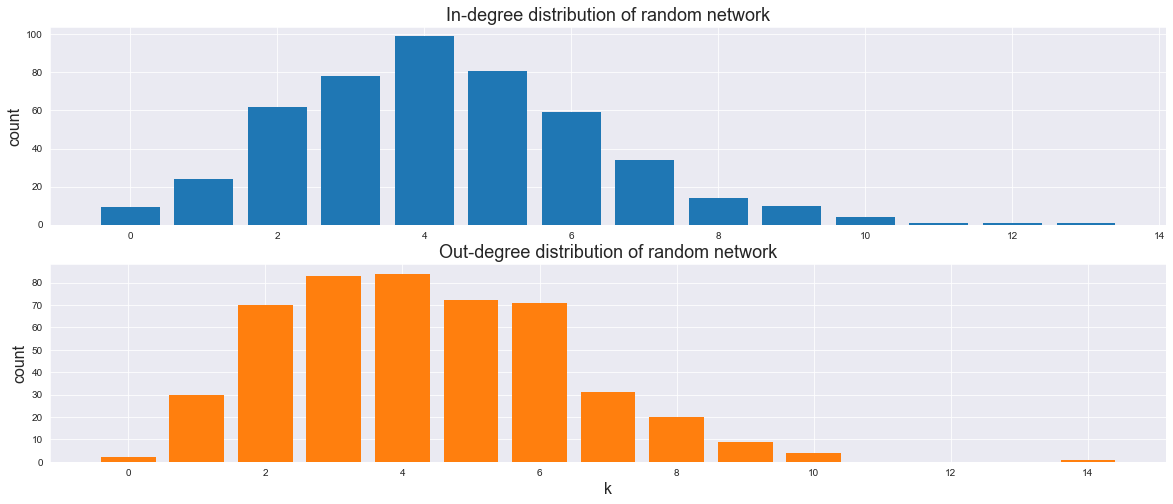

In [15]:
# In-degree distribution
degree_sequence = sorted([d for n, d in er.in_degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence)
bins, freq = zip(*degreeCount.items())

# Out-degree distribution
degree_sequence2 = sorted([d for n, d in er.out_degree()])  # degree sequence
degreeCount2 = collections.Counter(degree_sequence2)
bins2, freq2 = zip(*degreeCount2.items())

# Plotting distribution
fig, ax = plt.subplots(2,1, figsize=(20,8))
ax[0].bar(bins,freq, edgecolor="none")
ax[0].set_title('In-degree distribution of random network', fontsize=18)
ax[0].set_ylabel('count', fontsize=16)

ax[1].bar(bins2, freq2, edgecolor="none", color='#ff7f0e')
ax[1].set_title('Out-degree distribution of random network', fontsize=18)
ax[1].set_ylabel('count', fontsize=16)
ax[1].set_xlabel('k', fontsize = 16)

The random network is following a binomial distribution, but is well approximated by a Poisson distribution since *N* is fairly large and $N>> \langle k \rangle$. The peaks of the distributions are found at the average degree $\langle k \rangle$. The degree distribution is far from what was observed in the politicians network in regards to how many bins there are and the distribution shapes.

## Giant Connected Component <a class="anchor" id="5-bullet"></a>

Moving on to examine the giant connected component. The giant connected component consists of 307 politicians and 993 edges. The rest of this project is build on analysis performed on the giant connected component. The in and out-degree distribution for the giant connected component is visualised below.

In [17]:
# Number of nodes:
print("The politician network has", len(GCC), "nodes and", GCC.size(), "number of edges")

The politician network has 307 nodes and 993 number of edges


Text(0.5, 0, 'k')

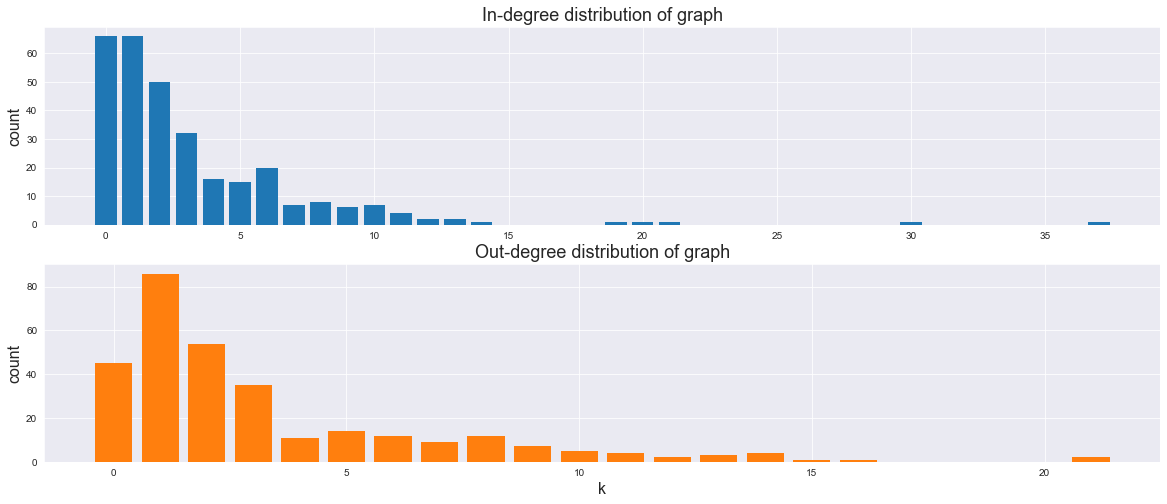

In [18]:
# In-degree distribution
degree_sequence = sorted([d for n, d in GCC.in_degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence) # count
bins, freq = zip(*degreeCount.items())

# Out-degree distribution
degree_sequence2 = sorted([d for n, d in GCC.out_degree()])  # degree sequence
degreeCount2 = collections.Counter(degree_sequence2) # count
bins2, freq2 = zip(*degreeCount2.items())

# Plotting distribution
fig, ax = plt.subplots(2,1, figsize=(20,8))
ax[0].bar(bins,freq, edgecolor="none")
ax[0].set_title('In-degree distribution of graph', fontsize=18)
ax[0].set_ylabel('count', fontsize=16)

ax[1].bar(bins2, freq2, edgecolor="none", color='#ff7f0e')
ax[1].set_title('Out-degree distribution of graph', fontsize=18)
ax[1].set_ylabel('count', fontsize=16)
ax[1].set_xlabel('k', fontsize = 16)

Likewise as for the entire network, both in and out-degree seem to follow a power-law distribution, meaning that the network is scale free. Though, the out-degree distribution does not seem to follow a power-law distribution to the same extend as before. 

## Most Connected Politicians <a class="anchor" id="6-bullet"></a>

The entire network's degree distribution has been examined, but how are the in and out-degrees of different politicians? It will be examined whether it is true, that the network consists of few highly connected politicians that functions as hubs. This is done by finding the most connected politicians according to in-degree and out-degree. The result can be seen below.

This function below is defined to include data labels in the bar plots. The code was found on [Matplotlib 3.1.1 documentation page](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html), some small changes have been made.

In [27]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        else: # Added, puts data labels underneath if height < 0
            ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),  # 12 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

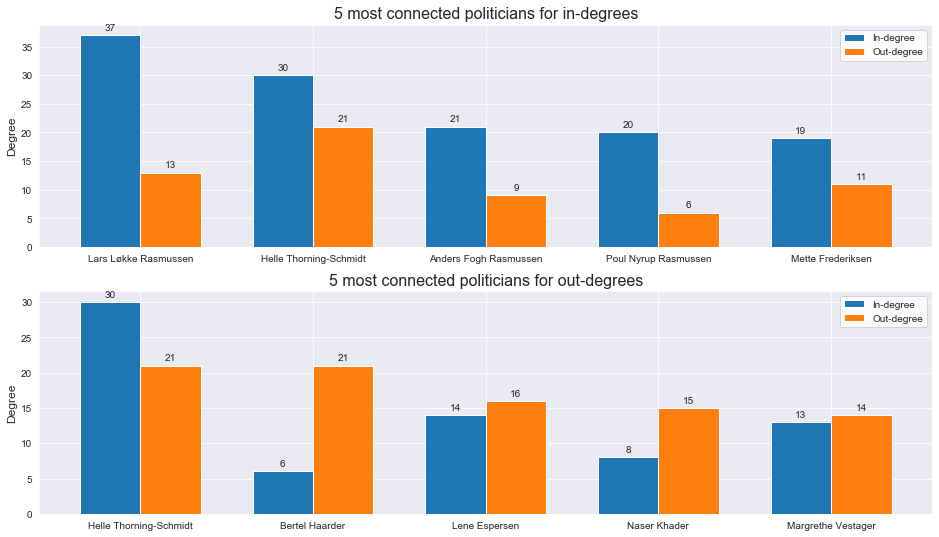

In [28]:
# In-degree and out-degree of most connected politicians
fig, ax = plt.subplots(2,1, figsize=(16,9))

#### Plot 1 - Top in-degree ####
bins, freq = zip(*collections.Counter(dict(GCC.in_degree())).most_common(5))
outfreq = [dict(GCC.out_degree())[i] for i in bins]

ind = np.arange(len(freq)) # the x locations for the groups
width = 0.35 # the width of the bars

rects1 = ax[0].bar(ind-width/2, freq, width, label="In-degree") # plotting in-degree
rects2 = ax[0].bar(ind+width/2, outfreq, width, label="Out-degree") # plotting out-degree
ax[0].set_xticks(ind)
ax[0].set_xticklabels(bins)
ax[0].set_ylabel('Degree', fontsize = 12)
ax[0].set_title('5 most connected politicians for in-degrees', fontsize=16)
ax[0].legend(facecolor='white')

# Using defined function for data labels
autolabel(rects1, ax[0])
autolabel(rects2, ax[0])

#### Plot 2 - Top out-degree ####
bins, freq = zip(*collections.Counter(dict(GCC.out_degree())).most_common(5))
infreq = [dict(GCC.in_degree())[i] for i in bins]

ind = np.arange(len(freq)) # the x locations for the groups
width = 0.35 # the width of the bars

rects1 = ax[1].bar(ind-width/2, infreq, width, label="In-degree") # plotting in-degree
rects2 = ax[1].bar(ind+width/2, freq, width, label="Out-degree") # plotting out-degree
ax[1].set_xticks(ind)
ax[1].set_xticklabels(bins)
ax[1].set_ylabel('Degree', fontsize = 12)
ax[1].set_title('5 most connected politicians for out-degrees', fontsize=16)
ax[1].legend(facecolor='white')

# Using defined function for data labels
autolabel(rects1, ax[1])
autolabel(rects2, ax[1])

The most connected politicians based on in-degree are either the current prime minister or former prime ministers. This seems reasonable as prime ministers are well-known and interact with a lot of different politicians. The out-degree of these politicians are mostly low, though, the out-degree of Helle Thorning-Schmidt is also rather high, actually the highest in the entire network. The current prime minister and the former prime ministers can be denoted as hubs as these have high in-degree and low out-degree with the exception of Helle Thorning-Schmidt. The most connected politicians based on out-degree are also well-known politicians. These politicians might point towards less known politicians. 

It is interesting to examine if any political parties on average have a higher degree than other parties. The plot below shows the results.

In [29]:
# Get in-degree and out-degree of all politicians 
temp_df = pd.DataFrame(list(GCC.nodes.data('Party')), columns=["Name", "Party"])
temp_df['in_deg'] = [GCC.in_degree(i) for i in temp_df['Name']]
temp_df['out_deg'] = [GCC.out_degree(i) for i in temp_df['Name']]

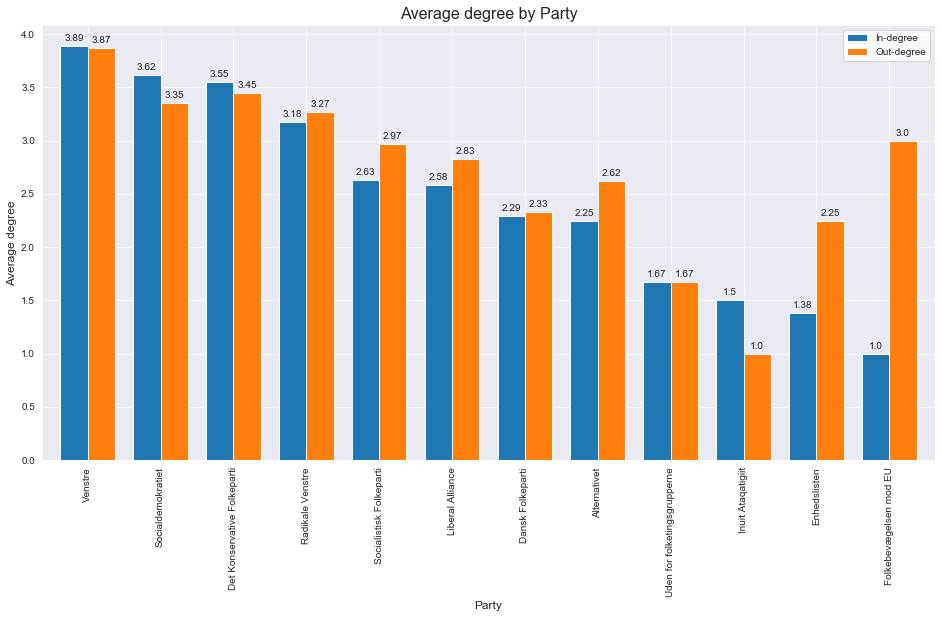

In [30]:
# Plotting average degree by party
fig, ax = plt.subplots(figsize=(16,8))
rects = temp_df.groupby('Party').mean().sort_values(by='in_deg', ascending=False).round(2).plot.bar(ax=ax, width = 0.75);
ax.set_ylabel('Average degree', fontsize = 12)
ax.set_xlabel('Party', fontsize = 12)
ax.set_title('Average degree by Party', fontsize=16)
ax.legend(["In-degree", "Out-degree"], facecolor='white')

# Adding data labels
autolabel(rects.containers[0], ax)
autolabel(rects.containers[1], ax)

Generally larger parties tend to have a higher average in-degree and out-degree. The parties Enhedslisten and Folkebevægelsen mod EU has the lowest in-degree, this imply that these parties have few highly connected politicians. 

## Age Distribution Across Different Parties <a class="anchor" id="7-bullet"></a>

Different parties had different average degrees, but how is the age distribution across different parties?
The age distribution of the different parties can be seen below.

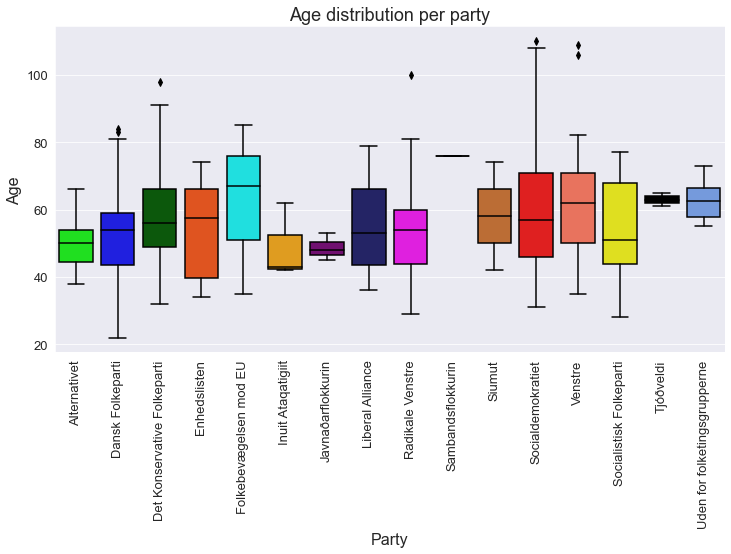

In [23]:
# Plotting age distribution by party
colors = ['lime','blue','darkgreen','orangered','cyan','orange','purple','midnightblue','magenta','grey','chocolate'
          ,'red','tomato','yellow','black','cornflowerblue']

fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(y=politicians.age, x=politicians.party, orient='v',palette=colors)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90); 
ax.set_xlabel("Party",fontsize =16) 
ax.set_ylabel("Age",fontsize =16) 
ax.tick_params(labelsize=13)
ax.set_title("Age distribution per party", fontsize=18);

As the network contains former politicians, some of the politicians in the network have passed away. This explains why some of the politicians are more than 100 years old. The parties with lowest average age are Inuit Ataqatigiit and Javnaõarflokkurin. The largest parties have politicians across different age demographics. 

The basic statistics of the politician network has been completed, and it is time to start examining the text data.

# Tools, Theory and Analysis <a class="anchor" id="8-bullet"></a>

To understand the network better, the degree distribution of the nodes in the network were calculated. This gave an insight into which nodes were the most connected in the network. The most connected nodes are probably also the most 'important' politicians with important roles in the society. 

To understand the difference in the language used to write about the politicians on Twitter compared to Wikpedia, word clouds and sentiment analysis are made. These two methods analyse two different aspects of the language used. Word clouds can be useful to understand which words are used to describe the politicans, whereas sentiment analysis can be useful to understand the tone used in the writing. More practically, the word clouds are created using the term frequency invserse document frequency (TFIDF) score. In general, a TFIDF score is used to measure how important a word is in a document compared to the collection of documents, a corpus. In this project every downloaded Wikipedia page for a politician is a document. The whole corpus contains all the Wikipedia texts. When making word clouds for Twitter text, all tweets about a certain politician are merged into one document. 

The documents from which the word clouds were generated, are used to perform the sentiment analysis. A score of how positive or negative the words are is needed. To do this, the `AFINN` library is used to score the sentiment of the words in the Danish texts. Before conducting the sentiment analysis, all stopwords are removed and the words are lemmatized. This way only a limited number of words with a potential sentiment score different from zero are used to conduct the sentiment analysis. 

To analyse how COVID-19 will spread in the network of Danish politicians, simmulations are made based on the SIR-model. A SIR-model is a mathematical model that models infectious diseases. In reality, COVID-19 would not spread as it will be vizualed since not all politicians meet each other physically even though they are connected in the network modelled in this project. Still, this simulation can be useful to understand at which rate COVID-19 would spread in such a group, where people meet up with different subgroups.  

## TFIDF Word Clouds <a class="anchor" id="9-bullet"></a>

In this section, word clouds are created based on Twitter and Wikipedia text. To create the word clouds the TFIDF score is calculated for each word. The TFIDF score is used to uniquely identify words that characterize each text. 

This function below "cleans" a string by tokenizing it, removing punctuation, converting to lower case, lemmatizing words and removing stop words. The function returns a list of "clean" tokens.

In [9]:
def cleanup(text):
    raw = BeautifulSoup(text, 'html.parser').get_text()
    tokens = word_tokenize(raw)
    # Remove all punctuation
    tokens= [t for t in tokens if t.isalnum()]
    # Set everything to lower case
    tokens=[t.lower() for t in tokens]
    # Lemmatize words
    wnl = nltk.WordNetLemmatizer()
    tokens = [wnl.lemmatize(t) for t in tokens]
    # Remove stopwords
    stopwords2 = stopwords.words('danish')
    tokens = [t for t in tokens if t not in stopwords2]
    return tokens

The function below removes politicians names in a string, so they don't appear in the word clouds. The input should be the clean tokens outputted from the function above. Politicians' names are omitted from the word clouds since they are not of interest. It is not of interest to see who a politician is associated with, but rather which topics or words that are associated with each politician. The function is only able to remove politicians from the strings that are a part of the dataframe. Since not all politicians are a part of the dataframe, some names of other politicians may still appear in the word clouds. 

In [88]:
#Function that removes all politicians names given in the dataframe from a list of clean tokens
def remove_name(string):
    namesplit=[i.lower().replace('-', ' ').split(" ") for i in politicians.name]
    namelist=[item for sublist in namesplit for item in sublist]
    string = [word for word in string if word not in namelist]
    return string    

The term frequncy (TF) score is calculated using the `FreqDist` function from `NLTK`. The TF list is used to calculate the augmented frequency, which prevents bias towards longer documents. The formula was found on the [TFIDF Wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

$$\text{tf}(t,d) = 0.5 + 0.5 \cdot \frac{f_{t,d}}{max\{f_{t',d}:t' \in d\}}$$

The inverse document frequency (IDF) factor for each document is calculated using the following formula, also from the Wikipedia page above:
$$\text{IDF}(t,D)=log\left(\frac{N}{d \in D: t \in D}\right)$$

where $N$ is the total number of documents in the corpus and $d \in D: t \in D$ is the number of documents where the term *t* appears i.e. $\text{tf}(t,d) \neq 0$. A factor *c* is not added to the denominator as it is only looped over words that occur in at least one text which means the denominator will never be 0.

Log is applied when calculating the IDF, in order to account for skewness towards large values, i.e. cases in which one or few points are much larger than average in the data.

TFIDF lists are then created by calculating:
 $$\text{TFIDF}(t,d,D)=\text{TF}(t,d)\cdot \text{IDF}(t,d)$$
 
The functions below do the jobs just described.

In [89]:
#Function that calculates the IDF score and stores in dictionary
def IDF(TF):
    # Get all keys
    keys=[list(i.keys()) for i in TF]
    # Make a list of all keys
    keys_unique=list(set([j for i in keys for j in i]))
    IDF=[]
    #Loop over all keys
    for key in keys_unique:
        count=0
        #Loop over all TF's
        for i in TF:
            # If key is in a TF count is increased by 1
            if key in i:
                count+=1
        # Calculate IDF for certain word   
        IDF.append(np.log(len(TF)/(count)))
    # Return it as a dictionary
    return dict(zip(keys_unique,IDF))

In [90]:
#Function that Calculates the TFIDF and stores in list of dictionaries
def TFIDF(TF, IDF):
    #Create an empty lsit
    TFIDFs=[]
    # Loop over all TF's
    for i in TF:
        # Create a new list
        TFIDF=[]
        #Loop over the keys and values in the given TF
        for key, value in i.items():
            # Calculate TFIDF for each key and value and append to list
            TFIDF.append(value*IDF[key])
        # Append the list of TFIDF to the final TFIDFs which is a list of lists 
        TFIDFs.append(dict(zip(i.keys(), TFIDF)))
    return TFIDFs

In [91]:
#Function that creates a string according to TFIDF score. 
#This string can be used to generate Word Clouds strings
def WordCloud_string(list_strings):
    # clean it
    text_clean=[cleanup(i) for i in list_strings]
    # remove name
    text_clean=[remove_name(i) for i in text_clean]
    # caculate FreqDist
    raw_text = [FreqDist(document) for document in text_clean]
    # calculate TF
    text_TF = [{term: 0.5 + 0.5*(frequency/max(tf.values())) for term, frequency in tf.items()} for tf in raw_text]
    # Calculate IDF
    text_IDF=IDF(text_TF)
    # Calculate TFIDF
    text_TFIDF=TFIDF(text_TF,text_IDF)
    # Create the string
    text_string=[' '.join([(str(key)+' ')*math.ceil(value) for key,value in i.items()]) for i in text_TFIDF]
    
    return text_string

The function below generates the word cloud plots from a given string. In the string the words should appear as many times as their TFIDF score. 

In [92]:
#Function that plots Word Clouds
def WordCloudGenerate(text, color,i, mask=False,name='WordCould'):
    # Generate a word cloud image
    if mask==False:
        wordcloud = WordCloud(collocations=False, background_color='white', max_font_size=50,
                         color_func = get_single_color_func(color)).generate(text)
    else:
        #pic_mask=np.array(Image.open(os.path.join(path,mask)))
        pic_mask=np.array(Image.open('Word Clouds/Masks/'+str(mask)))
        
        wordcloud = WordCloud(collocations=False, background_color='white', max_font_size=50, mask=pic_mask,
                         color_func = get_single_color_func(color)).generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    #plt.savefig('Word Clouds/WordCloudsSaved/'+name+str(i)+'.png',dpi=1000)   # save the figure to file
    #plt.close()
    return

### Parties <a class="anchor" id="10-bullet"></a>

Word clouds for each party are created below. First the dataframe is grouped by party and the Wikipedia text for the party members are concatenated into one big string. The word clouds are generated from this concatenated string. The party letters are used as masks for the word cloud plots. 

In [30]:
#Get a string for for all parties
party = politicians.groupby(['party'])['pages'].apply(','.join).reset_index()
party_text=[text for text in party.pages]
party_string = WordCloud_string(party_text)

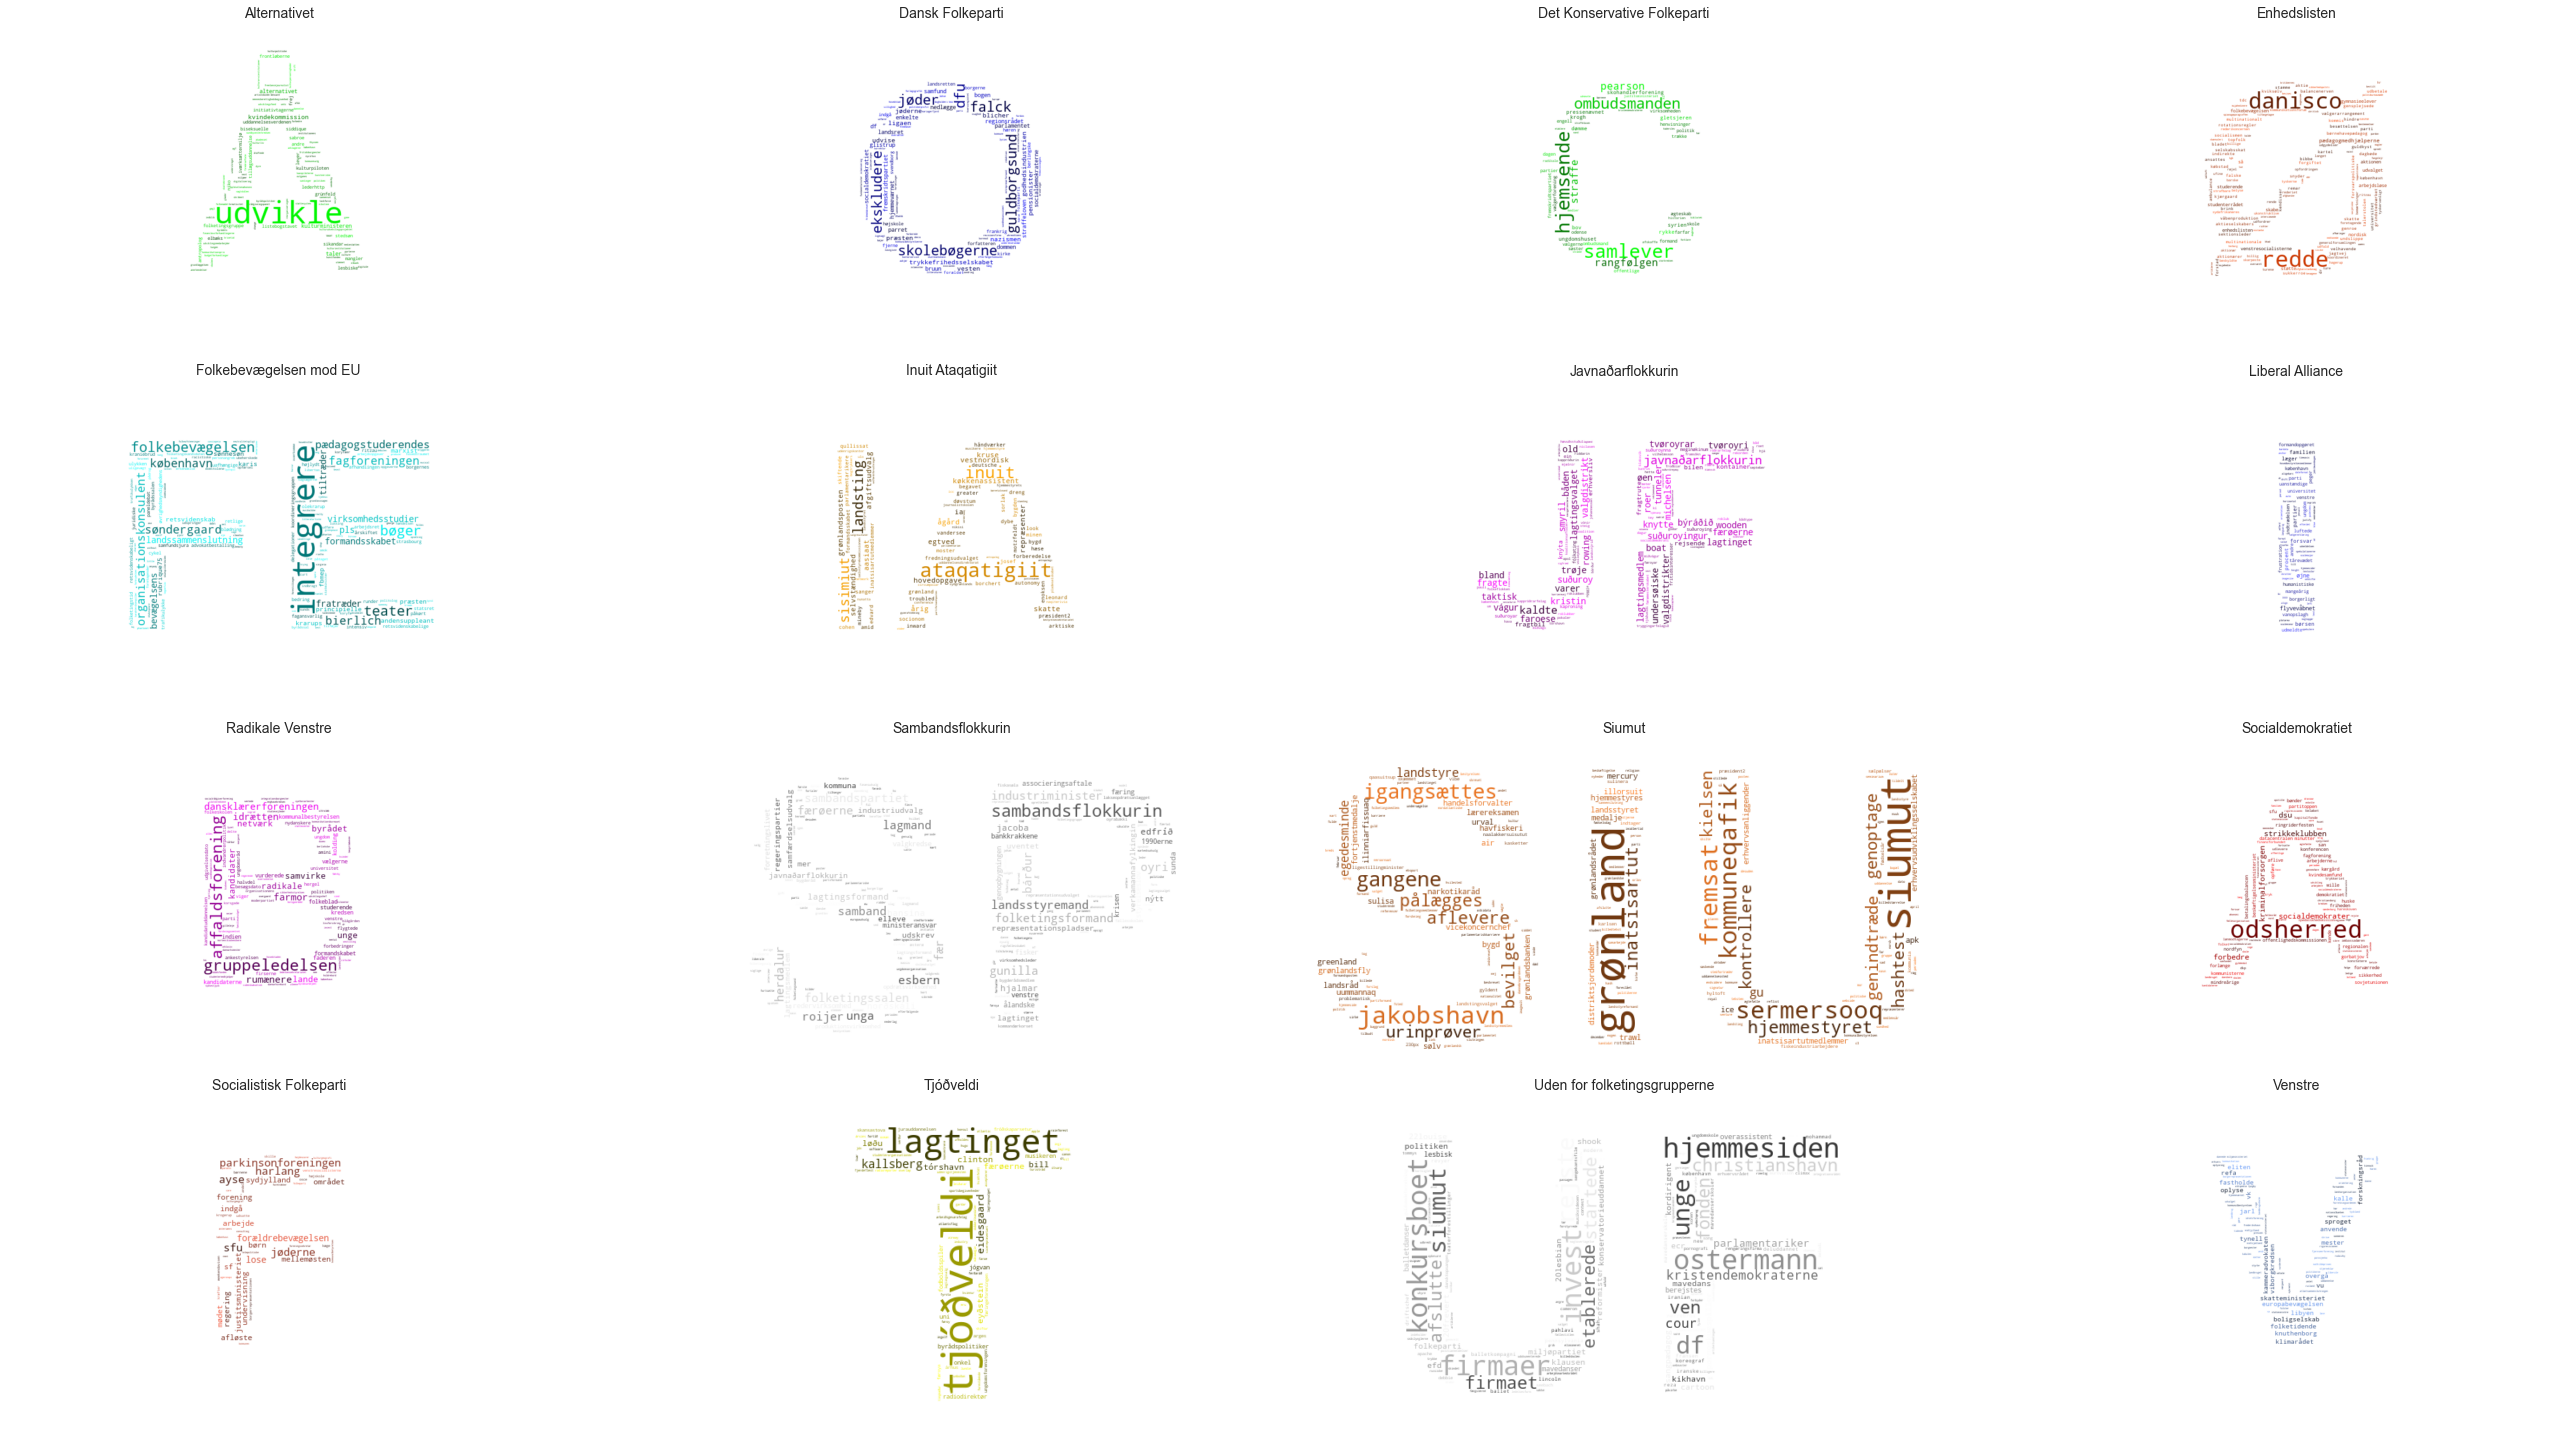

In [31]:
#Create the word clouds
colors = ['lime','blue','darkgreen','orangered','cyan','orange','purple','midnightblue','magenta','grey','chocolate'
          ,'red','tomato','yellow','black','cornflowerblue']
picture=['ALT.png','DF.png','KF.png','EL.png','FE.png','IA.png','JF.png','LA.png','RV.png','SP.png'
         ,'SIU.png','S.png','SF.png','T.png','UF.png','V.png']

f = plt.figure(figsize=(40,20))

for i in range(len(party_string)):
    f.add_subplot(4, len(party_string)/4, i+1).set_title(f"{party.party[i]}", fontsize=14)
    WordCloudGenerate(party_string[i], colors[i],i=i,mask=picture[i],name='Party_new')

plt.show()

It is clearly seen that some words are of importance in the Wikipedia texts for the different parties. For example the word 'udvikle' (develop) is much larger than the rest of the words in the word cloud of Alternativet. Likewise the word 'integrere' (integrate) is important in the word cloud of Folkebevægelsen mod EU. Some other interesting findings of important words include 'udvise' (deport) in the the word cloud of Dansk Folkeparti, whom is known for having a harsh immigration policy. The  word 'Strikkeklubben' (knitting club) appears in the word cloud of Socialdemokratiet. This could refer to their publically known alliances within the party. Theses findings can be compared to the words used to describe the parties on Twitter. 

### Wing <a class="anchor" id="11-bullet"></a>

Word clouds for the the different wings are created below. There are three wings in Danish politics: blue, red and green. The green wing only consists of one party, namely Alternativet. Some parties are not a part of a wing. They are all grouped together in the one group called no blok wing. 'Blok' means wing in Danish. 

In [32]:
#Get a string for for all bloks
blok = politicians.groupby(['blok'])['pages'].apply(','.join).reset_index()
blok_text=[text for text in blok.pages]
blok_string = WordCloud_string(blok_text)

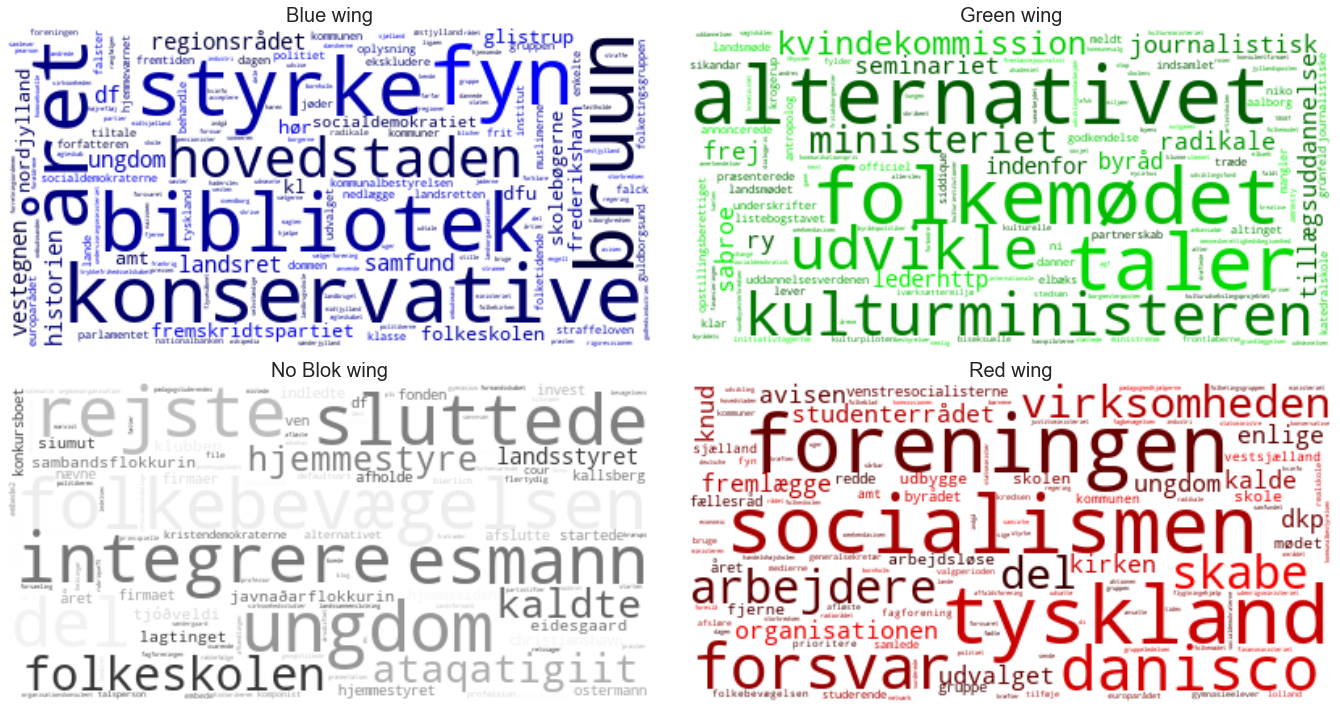

In [33]:
# Create the word clouds for political wing
f = plt.figure(figsize=(20,10))
color_blok=["blue", "green", "black","red"]
for i in range(len(blok_string)):
    f.add_subplot(2, len(blok_string)/2, i+1).set_title(f"{blok.blok[i]} wing", fontsize=20)
    WordCloudGenerate(blok_string[i], color_blok[i], i=i, name='Blok')

plt.show()

Some of the important words that characterize the wings are expected and some are more surprising. The word 'konservative' (conservative), which appears as an important word that characterizes the blue wing, was somewhat expected as this wing has the most conservative ideologies. Similarly the word 'socialismen'(socialism) was expected for the red wing as all the socialist parties belong to this wing. 

Other words such as 'hovedstaden'(capital region) for the blue wing was not as expected but somehow this word characterize the blue wing. Maybe the politically interested reader will know why this word appears in the word cloud. 

### Prime Ministers <a class="anchor" id="12-bullet"></a>

Word Clouds for the current and former Danish prime ministers are also created. The wikipedia pages for these politicians are on average significantly longer than for the rest of the politicians included in the network. Therefore there are many words that can be included in the analysis.  

In [93]:
# Selecting former prime ministers
primeminister_list = ['Lars Løkke Rasmussen', 'Helle Thorning-Schmidt','Anders Fogh Rasmussen'
                 ,'Poul Nyrup Rasmussen', 'Mette Frederiksen','Poul Schlüter','Anker Jørgensen','Poul Hartling']

#Get a string for for all prime ministers
primeminister = politicians[politicians.name.isin(primeminister_list)][['name','pages','blok']]
primeminister_text=[text for text in primeminister.pages]
primeminister_string = WordCloud_string(primeminister_text)

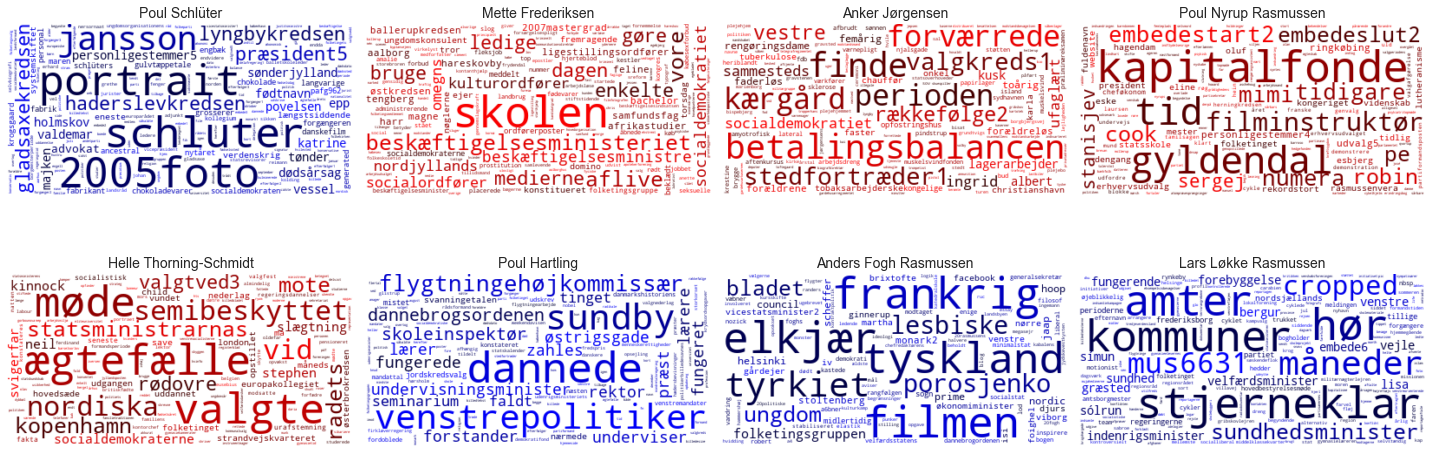

In [35]:
# Create the word clouds
f = plt.figure(figsize=(20,10))

for i in range(len(primeminister_string)):
    f.add_subplot(2, len(primeminister_string)/2, i+1).set_title(f"{list(primeminister.name)[i]}", fontsize=14)
    WordCloudGenerate(primeminister_string[i],  list(primeminister.blok)[i].lower(),i=i,name='Primeminister')

plt.show()

Looking at word clouds for just a single person, many of the words in the word clouds can easilly be associated with events. Some examples are:
- The word 'aflive (to put to sleep)' that appears in the word cloud for Mette Frederiksen. This word refers to the thousands of minks that were ordered to be killed by the Danish government in order to stop the spread of the  mutated Corona virus. 
- The word 'ægtefælle' (spouse) appears in the word cloud for Helle Thorning-Schmidt. This refers to the discussion about whether her husband should pay tax in Denmark. 
- The word 'kommuner' (municipalities) appears in the word cloud for Lars Løkke Rasmussen. This referes to the structural reform of the municipalities that was passed when he was health and domestic minister. 

In total the word clouds gives a good summary of the most important highlights on the wikipedia pages for the current and former primeministers. 

### Twitter Word Clouds <a class="anchor" id="13-bullet"></a>

Word clouds for the wings using Twitter data is generated below. 

In [95]:
#Get a string for for all bloks (wings)
blok = politicians.dropna().groupby(['blok'])['tweet'].apply(','.join).reset_index()
blok_text=[text for text in blok.tweet]
blok_string = WordCloud_string(blok_text)

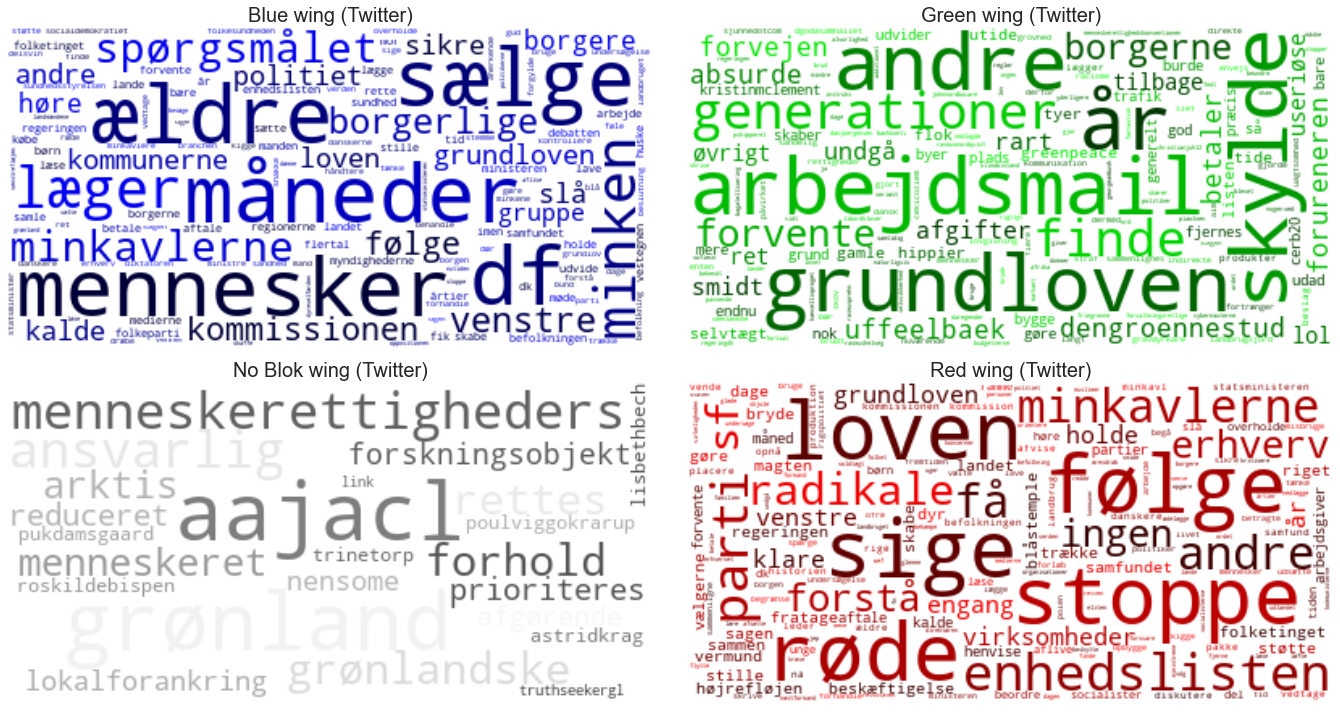

In [96]:
# Plotting word clouds for each political wing
f = plt.figure(figsize=(20,10))
color_blok=["blue", "green", "black","red"]
for i in range(len(blok_string)):
    f.add_subplot(2, len(blok_string)/2, i+1).set_title(f"{blok.blok[i]} wing (Twitter)", fontsize=20)
    WordCloudGenerate(blok_string[i], color_blok[i], i=i, name='Blok_tweet')

plt.show()

It is seen that the Twitter word clouds consist of more recent news. The word 'minkavlerne' (mink farmers) appears in the word clouds for the red and blue wing. This refers to the recent mink scandal where approximately a million minks were put to sleep because of a potential dangerous mutation in the COVID-19 virus. Also the words 'grundloven' (Constitution) and 'loven' (law) appear in three out of four of the word clouds. This probably also refers to the mink scandal. 

Generally, the word clouds using the Twitter data is based on more recent events, while the words clouds of the Wikipedia texts are based on highlights from several decades. 

## Sentiment Analysis <a class="anchor" id="14-bullet"></a>

The word clouds illustrated the words that were most common and unique for different groups. This gave an insight into what topics or events different parties, wings and prime ministers have focused on or been a part of. The word clouds provided insight, but they did not cover the sentiment of the different groups or situations. This section focuses on the sentiment of the Wikipedia coverage compared to tweets from Twitter. Furthermore, the tweets will be used to examine sentiment scores over time starting at November 16th and ending at December 2nd. It will be attempted to tie events to significant peaks to explain why and how the Twitter users tweeted about the Danish politicians.

The sentiment analysis will be based on Finn Årup Nielsen's Python library [`AFINN`](https://github.com/fnielsen/afinn). The library provides a score between -5 and 5 indicating negative and positive sentiment respectively. The calculation of the sentiment scores will not include words, that are not in the library i.e. have a sentiment score of 0.0, as the average sentiment score of a tweet or Wikipedia page become extremely small if many of the words are not in the library.

First, both the politicians Wikipedia pages and the tweets are cleaned using the `cleanup` function defined earlier. Afterwards three sentiment functions are defined. The first one computes the average sentiment score of a list of tokens, the second visualizes 5 different graphs depending on the text and dataframe given. The third function ensures that only politicians who have more than 30 words with sentiment are included in the first part of this sentiment analysis.

In [47]:
# Clean the wikipedia text and the tweets
text=[cleanup(i) for i in politicians.pages]
df_twitter=politicians[politicians['tweet'].notnull()]
tweet=[cleanup("".join(i)) for i in df_twitter.tweet]

In [8]:
# Function that calculates sentiment scores
def sentimentscore(tokens):
    # Load Afinn Library
    afinn = Afinn(language='da')
    happy_score=0
    count=0
    nul=[]
    # Loop over all tokens
    for t in tokens:
        #if t in namelist:
            #nul.append(t)
        # append t if sentiment of t is zero
        if afinn.score(t)==0.0:
            nul.append(t)
        # else plus score to happy_score 
        else:
            happy_score+=float(afinn.score(t))
            count+=1
    # if count is zero return sentiment of zero
    if count==0:
        return 0
    else: 
        # Calculate sentiment
        return happy_score/count

In [76]:
# Function that generates plot
def SentimentAnalysis(text,politicians, string):
    sentiment_page=[round(sentimentscore(i),2) for i in text]
    happy_dict=dict(zip(politicians.name,sentiment_page))
    
    # Distribution of Happy Scores
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    plt.hist(sentiment_page, bins=30);
    ax.set(title="Politicians Happy Score", ylabel="Frenquncy", xlabel="Happy Score");
    
    # Find the 10 happiest
    bins, freq = zip(*collections.Counter(happy_dict).most_common(10))
    freq = np.round(freq,4)
    colormap = ["firebrick" if i < 0 else "green" for i in freq]
    
    fig, ax = plt.subplots(figsize=(12,6))
    plt.xticks(rotation=90)
    rects1 = ax.bar(bins, freq, color=colormap)
    ax.set_ylabel('Happy score', fontsize = 12)
    ax.set_title('Happiest 10 politicians', fontsize=16)
    autolabel(rects1, ax)
    
    # Finds the saddest 10 characters
    bins, freq = zip(*collections.Counter(happy_dict).most_common()[:-10-1:-1])
    freq = np.round(freq,4)
    colormap = ["firebrick" if i < 0 else "green" for i in freq]
    
    fig, ax = plt.subplots(figsize=(12,6))
    plt.xticks(rotation=90)
    rects1 = ax.bar(bins, freq, color=colormap)
    ax.set_ylabel('Happy score', fontsize = 12)
    ax.set_title('Saddest 10 politicians', fontsize=16)
    autolabel(rects1, ax)
       
    # Average Happy score according to party
    politicians['happy score']=sentiment_page
    bins=dict(politicians.groupby("party").mean().sort_values("happy score", ascending=False)['happy score'].round(3)).keys()
    freq=dict(politicians.groupby("party").mean().sort_values("happy score", ascending=False)['happy score'].round(3)).values()
    colormap = ["firebrick" if i < 0 else "green" for i in freq]
    
    fig, ax = plt.subplots(figsize=(12,6))
    plt.xticks(rotation=90)
    rects1 = ax.bar(bins, freq, color=colormap)
    ax.set_ylabel(' Average Happy score', fontsize = 12)
    ax.set_title(f'Average happy score according to party ({string})', fontsize=16)
    autolabel(rects1, ax)
    
    # Average Happy score according to Wing
    bins=dict(round(politicians.groupby("blok").mean()['happy score'],3)).keys()
    freq=dict(round(politicians.groupby("blok").mean()['happy score'],3)).values()
    colormap = ["firebrick" if i < 0 else "green" for i in freq]
    
    fig, ax = plt.subplots(figsize=(12,6))
    plt.xticks(rotation=90)
    rects1 = ax.bar(bins, freq, color=colormap)
    ax.set_ylabel('Happy score', fontsize = 12)
    ax.set_title('Average happy score according to wing', fontsize=16)
    autolabel(rects1, ax)

In [77]:
# only get sentiment score of politicians with more than 30 words with sentiment
def ListOfManySentiments(text):
    afinn = Afinn(language='da')
    index_list=[]
    for i in range(len(text)):
        not_nul=[]
        for t in text[i]:
                if afinn.score(t)!=0.0:
                    not_nul.append(t)
        if len(not_nul)>=30:
               index_list.append(i)
    
    return index_list           

In [78]:
# Apply functions
index_text=ListOfManySentiments(text)
index_tweet=ListOfManySentiments(tweet)
text_2=[text[i] for i in range(len(text)) if i in index_text]
tweet_2=[tweet[i] for i in range(len(tweet)) if i in index_tweet]

### Wikipedia <a class="anchor" id="15-bullet"></a>

The defined functions are run on the Wikipedia texts and tweets above. The graphs for the Wikipedia texts are displayed below. The first graph illustrates the distribution of the sentiment scores. The sentiment of the politicians ranges from -1.5 to 1, with most politicians having a negative sentiment. If no politicians were left out due to unrepresentative sentiment in the texts, the frequency of 0 would have been of biggest magnitude. 

The second graph show the 10 most positive politicians based on Wikipedia coverage. The overall most positive politician is Martin Lidegaard, a former minister of foreign affairs. There is a general tendency of the most positive politicians being former ministers. An explanation could be that the Wikipedia texts usually cover all the ministers' contributions to Danish politics.

The third graph shows the 10 most negative politicians based on Wikipedia coverage. The person with the most negative coverage is Niels Holck, actually he is not a politician. Niels Holck, also known as Niels Christian Nielsen, is the main suspect in the Purulia ammunition dropping case. He has been confused with the Danish politician Niels Christian Nielsen from Socialdemokratiet. It is reasonable that Niels Holck has the most negative coverage as his Wikipedia describes his terrorism claims in details. Frank Aaen has the second most negative coverage, this can be explained by all the controversies he has been a part of, namely the feud with Danisco regarding genetically modified plants.

The fourth graph show the average sentiment score of politicians in the different parties. This allows for a comparison of the general sentiment of each party. The party with the most positive coverage is Liberal Alliance whereas the party with the most negative coverage is Enhedslisten. The final graph show the average sentiment score per wing. The wing with the most negative coverage is the blue wing, if we exclude the few politicians that are not a part of any wing. The most positive wing is the green wing, which only consists of the party Alternativet. 

Genrally when making comparisons based on average measures, the sentiment scores tend to even out and get extremely close to zero. Most of the sentiment scores represented are low, which is in good agreement with Wikipedia being a neutral and informative media. The low sentiment scores can also be explained by its calculation, as it is the average of all words with sentiment for a given politician. It is very unlikely that Wikipedia only covers negative or positive aspects of a politician's actions, which results in a neutral sentiment score when calculating the mean.

C:\Users\Bruger\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


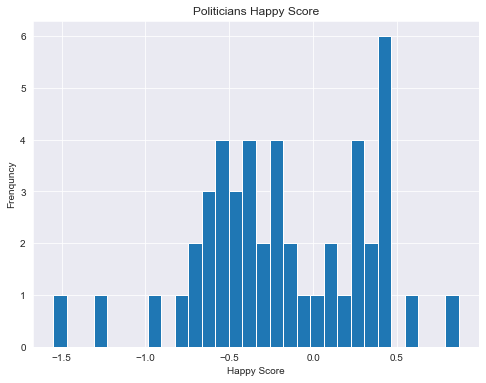

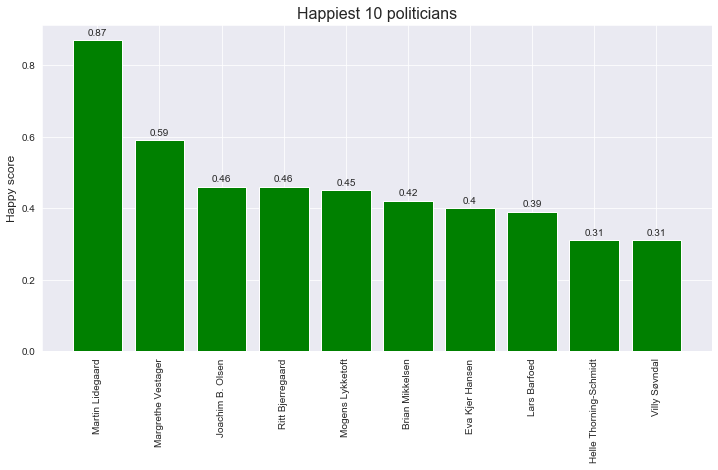

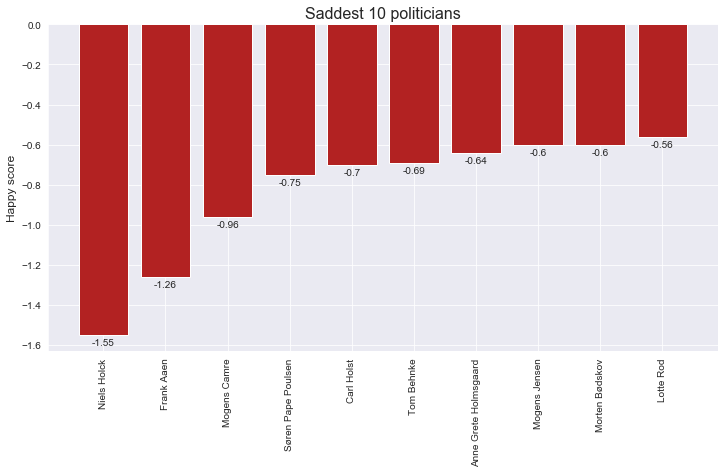

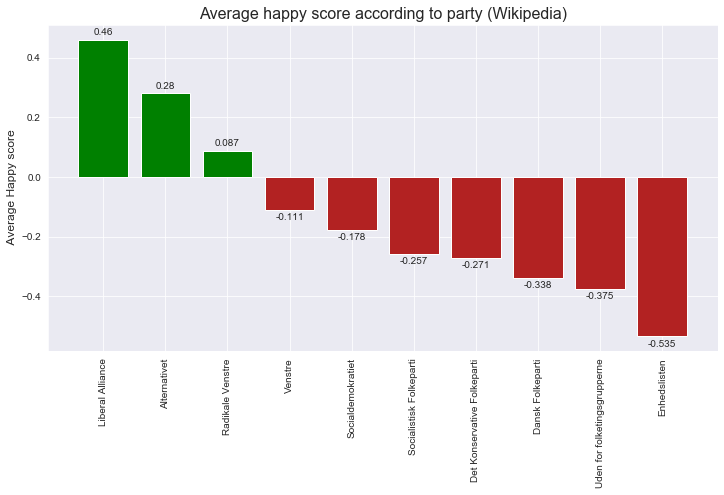

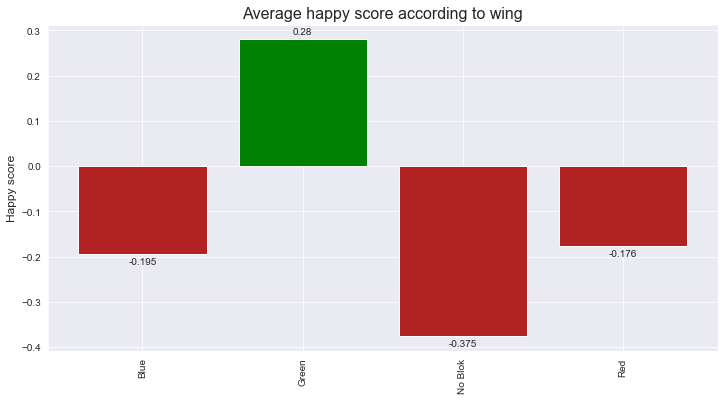

In [84]:
SentimentAnalysis(text_2,politicians.iloc[index_text,:], "Wikipedia")

### Twitter <a class="anchor" id="16-bullet"></a>

It is now time to compare the sentiment of Wikipedia with the sentiment of tweets. The plots below illustrate the same as above just for tweets regarding politicians with a twitter account. 133 politicians have a Twitter account and the tweets span from November 16th to December 2nd this year.

The first graph visualises the sentiment distribution. The sentiment scores ranges from -1 to 2, which makes the tweets more positive on average compared to the Wikipedia coverage. 

Moving on to the second graph, Rasmus Plehn has the most positive coverage. This might be due to all the congratulations he recieved after he was inducted as the new minister. The second most positive is Tommy Ahlers, who is a former minister. Generally, the positive sentiment scores of Twitter coverage are of bigger magnitude compared to the Wikipedia coverage.

The politician with the most negative coverage is Asger Christensen, who is a member of the committee on agriculture in the European parliament. The mink scandal mentioned previously have been criticized and therefore, Asger Christensen has been mentioned in a lot of negative tweets. Another negative politician is Pia Kjærsgaard, who is known for having strong beliefs on immigration policy and might be disliked because of this. 

The average sentiment per party shows, opposite to the Wikipedia coverage, that Liberal Alliance is the party with the most negative sentiment. Whereas the current government Socialdemokratiet has the most postive coverage. Furthermore, looking at the average score per wing, the red wing has the most positive sentiment score and the blue wing has the most negative sentiment score. 

The difference in magnitude of sentiment from tweets compared to Wikipedia text is not as big as expected. We had hoped to examine a bigger difference in the emotional expressions. Since the tweets are from the last two weeks it is difficult to compare the overall tone as the Wikipedia coverage is based on highligts from several years. The sentiment analysis of the tweets give an indication of what topics and issues that are relevant at the current moment in time. Another issue with using tweets is the style of writing. The Danes tweeting might use slang, irony or emojis to express their message, which are not understood by the `AFINN` library. 

C:\Users\Bruger\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


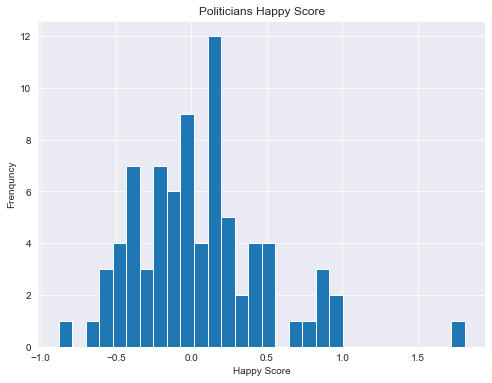

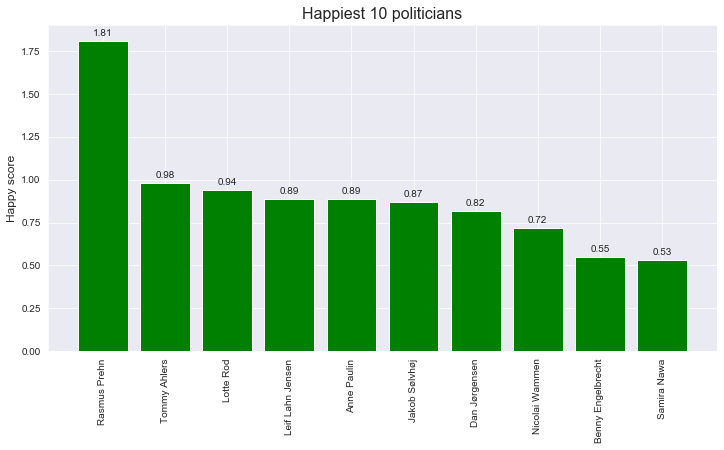

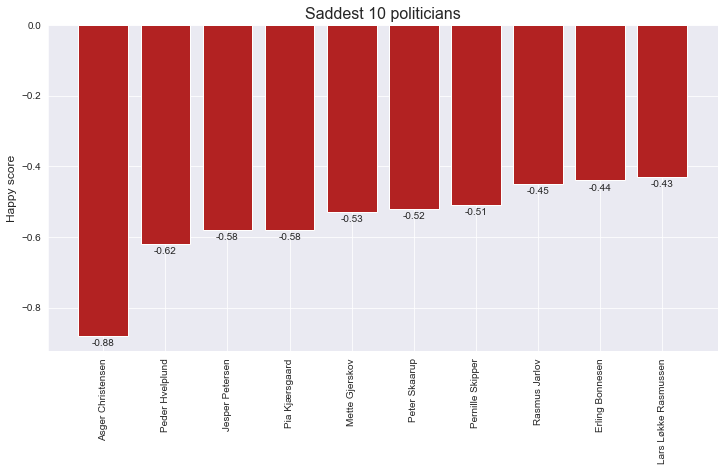

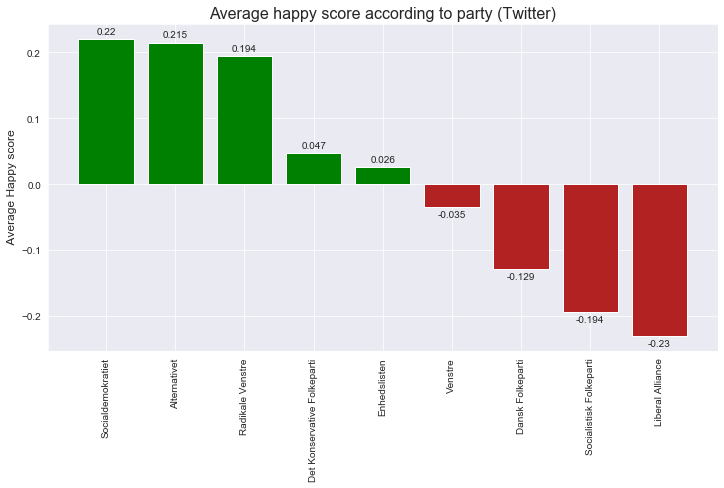

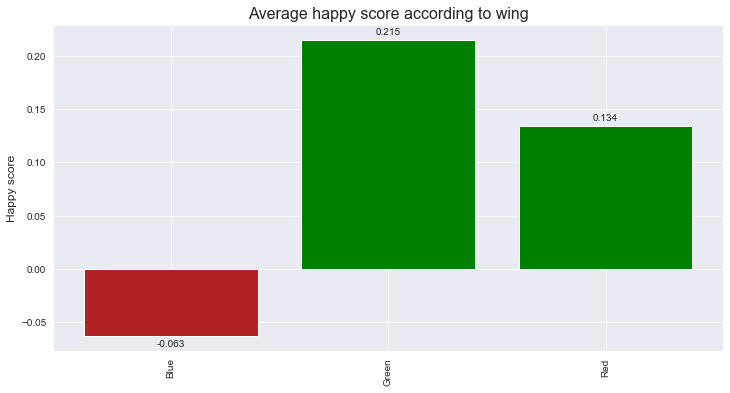

In [80]:
SentimentAnalysis(tweet_2,df_twitter.iloc[index_tweet,:], "Twitter")

### Sentiment Scores Over Time <a class="anchor" id="17-bullet"></a>

It is found that tweets yield information about the current events happening in Denmark, therefore, it could be interesting to examine how the sentiment score changes over time and if the sentiment scores could be tied to specific events. Furthermore, it could be interesting to analyze at what time a day Danes create the most postive and negative tweets. In order to accomplish this, the timestamps of tweets are saved and combined into one big dataframe. The dataframe rows consists of the politicians on Twitter and the columns are the tweets given on an hourly basis. The first few rows of the dataframe are displayed below.

The analysis will be based on the two largest parties, to ensure that there are as many tweets as possible at all timestamps. The two largest parties are Socialdemokratiet and Venstre and they will be represented by 35 and 28 politicians in this analysis respectively. The first graph below shows the sentiment score over time for the two parties.

In [3]:
tweet_time=pd.read_excel('TweetTime.xlsx',index_col=-1)
tweet_time.head(2)

2020-11-16 15:00:00  \
name                               
Uffe Elbæk                    []   
Torsten Gejl                  []   

                                            2020-11-16 16:00:00  \
name                                                              
Uffe Elbæk    ['@DenGroenneStud @uffeelbaek Forureneren beta...   
Torsten Gejl                                                 []   

                                            2020-11-16 17:00:00  \
name                                                              
Uffe Elbæk    ['@KristinMClement @uffeelbaek Endnu en god gr...   
Torsten Gejl  ['@taagf2019 @PHummelgaard @VictoriaRV @khoeng...   

             2020-11-16 18:00:00 2020-11-16 19:00:00 2020-11-16 20:00:00  \
name                                                                       
Uffe Elbæk                    []                  []                  []   
Torsten Gejl                  []                  []                  []   

             2020-11-16 21:00:00 2020-11-16 22:00:00  \
name                                                   
Uffe Elbæk                    []                  []   
Torsten Gejl                  []                  []   

                                            2020-11-16 23:00:00  \
name                                                              
Uffe Elbæk                                                   []   
Torsten Gejl  ['@PoulStruve @marie_bjerre @JerkelK @AdsbolAd...   

             2020-11-17 00:00:00  ...  \
name                              ...   
Uffe Elbæk                    []  ...   
Torsten Gejl                  []  ...   

                                            2020-12-02 05:00:00  \
name                                                              
Uffe Elbæk    ['@uffeelbaek @JeppeKofod Berøringsangst. \n\n...   
Torsten Gejl                                                 []   

                                            2020-12-02 06:00:00  \
name                                                              
Uffe Elbæk    ['@JesperLarsen32 @Storgaaard @uffeelbaek Uffe...   
Torsten Gejl                                                 []   

                                            2020-12-02 07:00:00  \
name                                                              
Uffe Elbæk    ['@uffeelbaek I går fra BBC om rydning af jung...   
Torsten Gejl  ['Juleønske 2020: Afskaffelse af GF i dette år...   

                                            2020-12-02 08:00:00  \
name                                                              
Uffe Elbæk    ['@uffeelbaek Fordi S godt kan huske, hvordan ...   
Torsten Gejl  ['@PHummelgaard Juleønske 2020: Afskaffelse af...   

                                            2020-12-02 09:00:00  \
name                                                              
Uffe Elbæk    ['@uffeelbaek @JeppeKofod Det er noget lettere...   
Torsten Gejl                                                 []   

                                            2020-12-02 10:00:00  \
name                                                              
Uffe Elbæk    ['@uffeelbaek @JeppeKofod @tedhuichifung @josh...   
Torsten Gejl                                                 []   

                                            2020-12-02 11:00:00  \
name                                                              
Uffe Elbæk    ['@uffeelbaek @JeppeKofod Handel, handel, hand...   
Torsten Gejl                                                 []   

                                            2020-12-02 12:00:00  \
name                                                              
Uffe Elbæk                                                   []   
Torsten Gejl  ['@TorstenGejl https://t.co/utOFJXV5WJ har en ...   

                                            2020-12-02 13:00:00  \
name                                                              
Uffe Elbæk    ["@friegronne @tedhuichifung @joshuawongcf @na...   
Torsten Gejl 

In [4]:
time=pd.merge(tweet_time, politicians[["name", "party"]],how="inner", on='name').set_index("name")

# Number of politicians on twitter from each party. Chooses to only look at Socialdemokratiet and Venstre.
time.groupby("party").size()

party
Alternativet                    2
Dansk Folkeparti               14
Det Konservative Folkeparti    12
Enhedslisten                   11
Inuit Ataqatigiit               1
Liberal Alliance                5
Radikale Venstre               13
Socialdemokratiet              35
Socialistisk Folkeparti        12
Venstre                        28
dtype: int64

In [5]:
#Function that calculates sentiment for each party
def sentiment_party(party,time, dates):
    #Combine all tweets of politicians in the party on a specific date
    text=["".join([item for sublist in list(time[time["party"]==party][date]) for item in sublist]) for date in dates]
    # Clean it
    clean=[cleanup(i) for i in text]
    # Calculate sentiment score
    return [round(sentimentscore(i),2) for i in clean]

In [10]:
# Run sentiment function and create a dataframe
dates=pd.to_datetime(time.columns[1:-1])
sentiment=pd.DataFrame(zip(sentiment_party('Socialdemokratiet', time, dates),sentiment_party('Venstre', time, dates)), columns=["Socialdemokratiet",'Venstre'] )
sentiment.index=dates

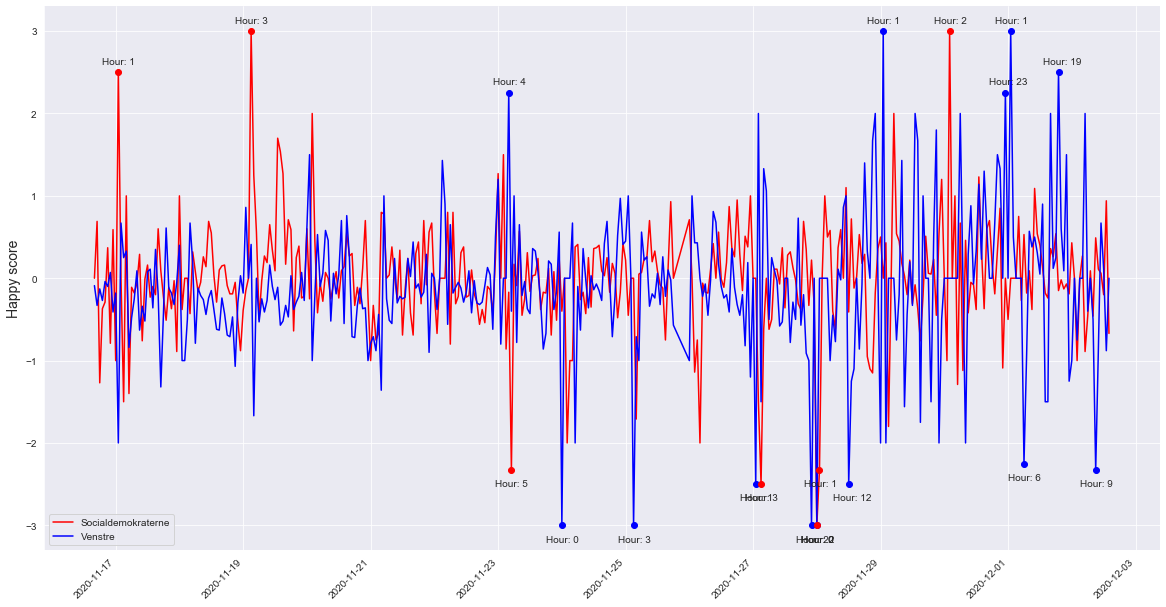

In [18]:
# Find all peaks in sentiment above plus minus 2 for the two parties 
peak_V=sentiment[abs(sentiment.Venstre)>2]["Venstre"]
peak_S=sentiment[abs(sentiment.Socialdemokratiet)>2]["Socialdemokratiet"]
dates=pd.to_datetime(time.columns[1:-1])

# Plot the result:
f,ax=plt.subplots(figsize=(20,10))
plt.plot(dates,sentiment['Socialdemokratiet'], color="red", label="Socialdemokraterne")
plt.plot(dates,sentiment['Venstre'],color="blue", label="Venstre")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

# Plotting points of peaks
[ax.plot(list(peak_V.index)[i], peak_V[i], 'o', color="blue") for i in range(len(peak_V))]
[ax.plot(list(peak_S.index)[i], peak_S[i], 'o', color="red") for i in range(len(peak_S))]

# Annotations on peaks
[ax.text(mdates.date2num(list(peak_V.index)[i])-0.25, peak_V[i]+0.1, "Hour: {}".format(list(peak_V.index)[i].hour)) 
 for i in range(len(peak_V)) if peak_V[i]>0]
[ax.text(mdates.date2num(list(peak_V.index)[i])-0.25, peak_V[i]-0.2, "Hour: {}".format(list(peak_V.index)[i].hour)) 
 for i in range(len(peak_V)) if peak_V[i]<0]
[ax.text(mdates.date2num(list(peak_S.index)[i])-0.25, peak_S[i]+0.1, "Hour: {}".format(list(peak_S.index)[i].hour)) 
 for i in range(len(peak_S)) if peak_S[i]>0]
[ax.text(mdates.date2num(list(peak_S.index)[i])-0.25, peak_S[i]-0.2, "Hour: {}".format(list(peak_S.index)[i].hour)) 
 for i in range(len(peak_S)) if peak_S[i]<0]

ax.set_ylabel("Happy score", fontsize=14)
plt.legend(loc="lower left");
# Despine
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#plt.savefig("ts_hourly.png", dpi=1000, bbox_inches="tight")

The average sentiment score over time is illustrated above. Clearly, the sentiment in the tweets have been increasing over time, as a lot of tweets in the end of November and start December have high sentiment scores. Generally, the most positive and negative tweets are posted during late nights or early mornings. The Danes tend to be most emotional at these times. Another explanation is, that few Twitter users tweets at these times, and therefore the few tweets posted result in more significant spikes. During the day, when everyone is awake, more tweets are created and an average sentiment score is more representative. These tweets might even out, as some of them are extremely positive or negative. It is difficult to tie events to an hourly basis, therefore an average sentiment score per day is calculated and visualised below.

In [12]:
# Sentiment scores per day
# Get dates without hour, minute and seconds
dates_clean=[str(list(time.columns)[i]).split()[0] for i in range(len(list(time.columns))-1)]

# Sort the list
d=sorted(list(set(dates_clean)))
indexes=[]
# Loop over all days and get the indexes for the columns on the same day
for k in d:
    indexes.append([i for i, x in enumerate(dates_clean) if x == k])

# Combine the the columns into one list and create a dataframe
combined=[]
for i in range(len(indexes)):
    combined.append(time.iloc[:,indexes[i]].values.tolist())

combined_time=pd.DataFrame(combined).T

# Remove unnessary empty lists
row=[]
column=[]
for j in range(combined_time.shape[1]):
    row=[]
    for i in range(combined_time.shape[0]):
        row.append(" ".join([item for item in combined_time.iloc[i,j] if item!='[]']))
    
    column.append(row)

# Make the final dataframe
day_time=pd.DataFrame(column).T
day_time.columns=d 
day_time=day_time.set_index(time.index)
day_time=pd.merge(day_time, politicians[["name", "party"]],how="inner", on='name').set_index("name")

In [13]:
# Call the sentiment function
dates2=list(day_time.columns[1:-1])
sentiment_day=pd.DataFrame(zip(sentiment_party('Socialdemokratiet', day_time, dates2),sentiment_party('Venstre',day_time, dates2)), columns=["Socialdemokratiet",'Venstre'])

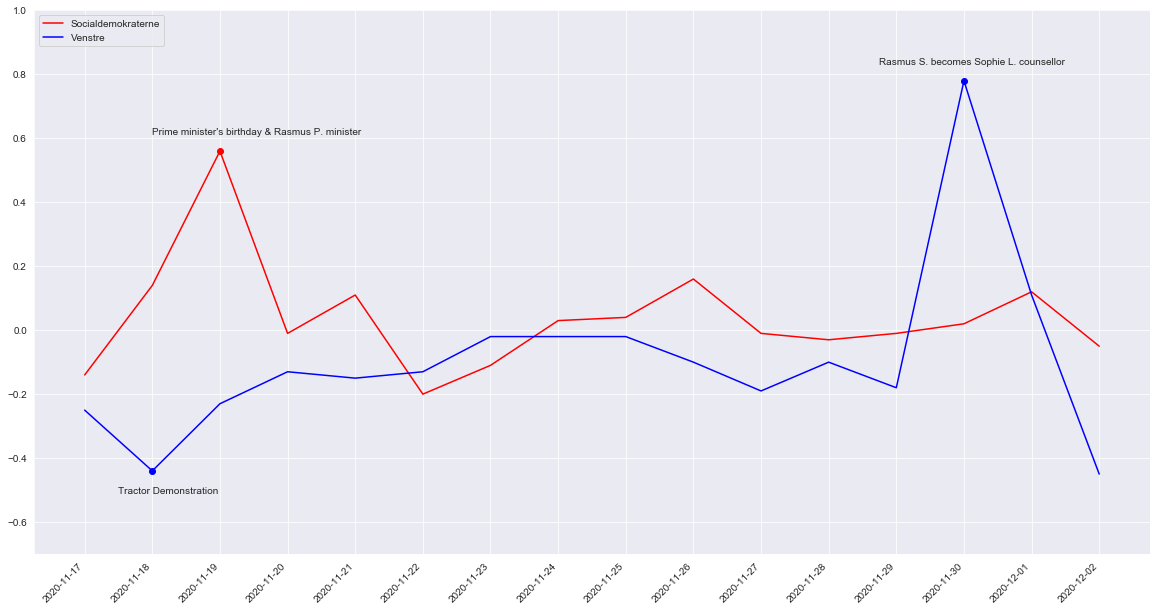

In [19]:
# Plot the result
f,ax=plt.subplots(figsize=(20,10))
plt.plot(dates2,sentiment_day['Socialdemokratiet'], color="red", label="Socialdemokraterne")
plt.plot(dates2,sentiment_day['Venstre'],color="blue", label="Venstre")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

# Annotations and points on peaks
ax.plot([2], sentiment_day['Socialdemokratiet'][2], 'o', color="red")
ax.text(1, sentiment_day['Socialdemokratiet'][2]+0.05, 'Prime minister\'s birthday & Rasmus P. minister ')
ax.plot(13, sentiment_day['Venstre'][13], 'o', color="blue")
ax.text(11.75, sentiment_day['Venstre'][13]+0.05, 'Rasmus S. becomes Sophie L. counsellor')
ax.plot(1, sentiment_day['Venstre'][1], 'o', color="blue")
ax.text(0.5, sentiment_day['Venstre'][1]-0.07, 'Tractor Demonstration')

ax.set_ylim([-0.7,1])
plt.legend(loc='upper left');
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#plt.savefig("Hjemmeside/ts_daily.png", bbox_inches = "tight", dpi = 1000)

The average sentiment score per day is presented above for the two largest parties. Interestingly, the two sentiment scores over time seem to be tied together, as a high sentiment score for Socialdemokratiet implies a low sentiment score for Venstre. The average sentiment scores over time have three significant peaks. It was possible to examine the tweets and tie them to current events. For instance the tweets associated with the large peak November 19th for Socialdemokratiet are mostly connected to the current prime minister Mette Frederiksen's birthday and the induction of Rasmus Prehn as the new minister. Likewise, the tweets associated with the large peak for Venstre at November 30th are mostly connected to Rasmus Sandal becoming Sophie Løhde's counsellor. Below are some of the tweets associated with each peak.

In [52]:
# Get tweets with highest sentiment scores
def GetMostSentimentTweet(att,a,b):
    tweet=[]
    val=[]
    days=[]
    # get the dayes where sentiment is above a
    events_day=[name for name,val in dict(zip(sentiment_day.index,sentiment_day[att])).items() if abs(val)>=a]
    # Loop through all the event days
    for i in events_day:
        # Calculate sentiment scores from the tweets from that day
        scores=[sentimentscore(i) for i in [cleanup(i) for i in list(set(day_time[day_time.party==att][dates2[i]]))]]
        # Get index
        index=[i for i,x in enumerate(scores) if abs(x)>=b]
        # append index and dates
        val.extend(index)
        [days.append(dates2[i]) for _ in range(len(index))]
        # Loop thorugh every index and append tweet
        for ind in index:
            tweet.append(list(set(day_time[day_time.party==att][dates2[i]]))[ind])
    return pd.DataFrame([val,tweet, days]).T
        

In [53]:
# Call the function above for both Venstre and Socialdemokratiet
V=GetMostSentimentTweet("Venstre",0.4,0.9)
V.columns=["Sentiment", "Tweet", "Date"]
S=GetMostSentimentTweet("Socialdemokratiet",0.4,1.5)
S.columns=["Sentiment", "Tweet", "Date"]

In [54]:
#Used to find the tweets below. 
#V[V["Date"]=="2020/11/30"]["Tweet"][8]
#S[S["Date"]=="2020/11/19"]["Tweet"][6]

Tweets from "2020/11/18": VENSTRE

**Event - Tractor Denmostration Aarhus**
  * "Over dobbelt så svært at få bolig, hvis du hedder Mohammad; “Jeg ved jo ikke om du er kriminel eller bandemedlem” #dkpol #dkbolig #dksocial @fatmaoektem @RStoklund @mattiastesfaye."
  * "@Loekkegaard_MEP @dkpol HOLD DIG TIL EU.. hvordan går det dernede.. i helvede.."
  * "@Loekkegaard_MEP @soolu03 @dkpol Venstre er til gengæld ligeglade med Inger Støjbergs gøren og laden. Det er hyklerisk!"
  * "Det pinlige er at der er så mange mennesker, som åbenbart synes at Mette er hævet over vores love. Alt dækkes ind under folkesundhed. Vores retssikkerhed er under hårdt pres. Ingen er hævet over grundloven, uanset politisk ståsted. Det har den røde del af DK åbenbart glemt."

Tweets from "2020/11/19": SOCIALDEMOKRATIET

**Event - Mette Frederiksens birthday & Rasmus Prehn becoming minister**
   * "Som en af verdens\\nstørste søfartsnationer skal vi bidrage med kapaciteter og viden, som gør det sikkert for søfarten og danske\\nsøfolk at færdes til søs. @Trinebramsen budskab i dag til @Maersk. '@Forsvarsmin @Trinebramsen @Maersk Jeg. Knuselsker. Trine. Bramsen. Sådan. Skulle lige af med det. Bedste forsvarsminister. @Trinebramsen, kipper med bøllehatten."
   * "@SylleSvb @LarsArneC @MetteGjerskov Omvendt har Karen Hækkerup haft posten før og været direktør i Landbrug  og Fødevare. Men alt er muligt også at posterne bare fordeles ud på andre ministre. Håber Daisy har et ekstra glas Champagne til Mette når hun kigger forbi på sin fødselsdag 🇩🇰🌹🇩🇰"
   * "Tillykke til @RasmusPrehn med posten som ny Fødevareminister - vi ser meget frem til samarbejdet med dig og @MFVMin og hos @DyrBeskyt er vi klar til bidrage med idéer for at sikre et mere bæredygtigt landbrug med bedre #dyrevefærd #miljø og #biodiversitet🧑"

Tweets from "2020/11/30": VENSTRE

**Event - Sophie Løhde hiring Rasmus Sand as new counseller**
   * "@SandRasmus @sophieloehde Stort tillykke, men tænker at det måske var bedre Inger fik lidt gode råd. Tænker at Sophie gør det udemærket 😉"
   * "@larsloekke Jeg ser ikke kun lanzerote som udfordring, jeg ser lufthavnene, trængsel ved indtjekning, bagagebåndene, flyveturen, transfer mm. Så blander du det i en cocktail med x antal andre landes turister og så kan du være næste smittebærer, hvordan er det ellers spredt før ? Tænk dig om\"
   * "@SandRasmus @sophieloehde Stort tillykke til jer begge to 😉"


## COVID-19 Simulation <a class="anchor" id="18-bullet"></a>

In this section, the spread of COVID-19 throughout our network of Danish politicians is simulated. For the simulation, the undirected giant connected component is considered, in order to ensure that the simulated disease can spread to all nodes. A susceptible-infected-recovered (SIR) model is considered, since we assume that one cannot contract COVID-19 after having it once. Before commencing with the simulation, we will calculate the most central node and least central node in the network according to centrality measures and their simulations will be compared.

### Centrality <a class="anchor" id="19-bullet"></a>
The centrality measures that we consider are the degree centrality and the betweenness centrality. The degree centrality is the simplest measure of the two, since it only considers how many neighbours a node has ([Franceschet](https://www.sci.unich.it/~francesc/teaching/network/degree.html)). 

One might raise an eyebrow if one were to look at the decimal numbers of the degree centrality displayed below without reading beyond, however this is due to the algorithm in `NetworkX` normalizing by the maximum possible degree for a simple graph with *n-1* nodes ([NetworkX Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html)). 

The betweenness centrality is a little more tricky. This measure is based on the shortest-path algorithm and is described for a node *v* by "the sum of fraction of all-pairs shortest paths that pass through *v*" ([NetworkX Betweenness](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)). This means that the more times that *v* is a part of a shortest path across the network, the higher the betweenness centrality score.

In [89]:
# Degree centrality - top 5
deg_c = nx.degree_centrality(GCCu)
FreqDist(deg_c).most_common(5)

[('Lars Løkke Rasmussen', 0.13725490196078433),
 ('Helle Thorning-Schmidt', 0.12745098039215685),
 ('Anders Fogh Rasmussen', 0.0784313725490196),
 ('Mette Frederiksen', 0.07516339869281045),
 ('Bertel Haarder', 0.07189542483660132)]

In [90]:
# Betweenness centrality - top 5
bet_c = nx.betweenness_centrality(GCCu)
FreqDist(bet_c).most_common(5)

[('Helle Thorning-Schmidt', 0.19778952942530292),
 ('Lars Løkke Rasmussen', 0.1509730294694629),
 ('Anders Fogh Rasmussen', 0.06995107649206342),
 ('Margrethe Vestager', 0.05524221647822315),
 ('Mette Frederiksen', 0.05382634319009)]

The politicians occuring in the top 5 for both centrality measures are well-known politicians in Denmark. Lars Løkke Rasmussen and Helle Thorning-Schmidt are both former prime ministers from respectively Venstre and Socialdemokratiet. The simulation will be conducted for one of these politicians.

Their simulation will be compared to their counterparts found below.

In [91]:
# Degree centrality - bottom 5
FreqDist(deg_c).most_common()[-5:]

[('Kristian Pihl Lorentzen', 0.0032679738562091504),
 ('Flemming Møller', 0.0032679738562091504),
 ('Karsten Nonbo', 0.0032679738562091504),
 ('Fatma Øktem', 0.0032679738562091504),
 ('Preben Rudiengaard', 0.0032679738562091504)]

In [92]:
# Betweenness centrality - bottom 5
FreqDist(bet_c).most_common()[-5:]

[('Kristian Pihl Lorentzen', 0.0),
 ('Flemming Møller', 0.0),
 ('Karsten Nonbo', 0.0),
 ('Fatma Øktem', 0.0),
 ('Preben Rudiengaard', 0.0)]

At the opposite end of spectrum are politicians, who are not widely known to the general population. Their degree centrality is far lower than seen previously and their betweenness centrality are all 0. This can be due to these nodes being on the periphery of the graph with only one edge, hence they will not be part of many shortest-path pairs.

### Simulating Pandemic <a class="anchor" id="20-bullet"></a>

The first function defined for the pandemic simulation is a function for converting a `matplotlib` figure to an image without saving it locally, found on [Stackoverflow](https://stackoverflow.com/questions/8598673/how-to-save-a-pylab-figure-into-in-memory-file-which-can-be-read-into-pil-image/8598881). The simulation will be saved as a GIF file, which essentially is a bunch of pictures that are shown with a delay between each.

In [93]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches ='tight')
    buf.seek(0)
    img = Image.open(buf)
    return img

The node positions are calculated with the ForceAtlas2 algorithm.

In [97]:
# The force atlas algorithm parameters will obtain the visualization we like
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(GCCu, pos=None, iterations=2000)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 194.10it/s]

BarnesHut Approximation  took  1.07  seconds
Repulsion forces  took  8.56  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.29  seconds


The function below simulates a SIR disease, finds convergence in the simulation, creates illustrations and saves them as a GIF file. The function takes a file name and start node as input, where the filename only determines the name of the outputted GIF file in the folder and the start node indicates from which node the simulation is started at.

The simulation will run 100 iterations although significantly less are needed before all nodes have recovered from the disease. The probability of a node infecting other nodes is set at $p=0.1$, which is probably the most important parameter of the simulation. This probability was used in the exercise from week 8 and is still used, since it was difficult to find information regarding the probability of contracting COVID-19 as it depends on numerous factors. Lastly, the recovery time for a node infected with COVID-19 is set at 10 days, which a bit lower than 2 weeks for mild cases according to [WHO](https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf). If it is changed nothing significant would happen, because we found that an infected node does infect all its neighbours within 10 time steps. 

In [105]:
# Function which simulates SIR disease and outputs GIF
def gifGen(filename, start_node):
    t = 0 
    iterations = 100
    p = 0.1 # Probability of infecting other nodes
    node_state = {}
    for node in list(GCCu.nodes):
        node_state[node] = ["grey"]*iterations # grey for susceptible

    # Find initial infected node
    inf_nodes = ['']*iterations
    inf_nodes[t] = [start_node]
    node_state[inf_nodes[t][0]][t:] = ["red"]*(iterations-t) # red for infected

    for t in range(1, len(inf_nodes)):
        iteration_inf_nodes = []
        for infected_node in inf_nodes[t-1]:
            # Find the susceptible neighbors of the infected node
                infected_neighbors = list(GCCu.neighbors(infected_node))
                suscetible_neighbors = [node for node in infected_neighbors if node_state[node][t] == "grey"]

                # Find new infected nodes and change their state in the dictionary
                n_infections = np.ceil(len(suscetible_neighbors)*p)
                new_infected_nodes = random.sample(suscetible_neighbors, int(n_infections))
                # Change state of infected nodes
                for node in new_infected_nodes:
                        node_state[node][t:] = ["red"]*(iterations-t)

        for node, state in node_state.items():
            if ("red" in state) and (t-state.index("red") >= 10) and ("green" not in state):
                node_state[node][t:] = ["green"]*(iterations-t) # green for recovered

        iteration_inf_nodes.extend([node for node, state in node_state.items() if node_state[node][t] == "red"])

        inf_nodes[t] = iteration_inf_nodes
    
    #### Finding out when the graph has converged ####
    # Creating dataframe of states where iteration is the column and nodes are rows
    df_state = pd.DataFrame([state for state in node_state.values()])

    col_list = []
    for column in list(df_state):
        count = 0
        for row in range(len(df_state)):
            if df_state[column][row] is "green" or df_state[column][row] is "grey":
                count += 1
        # If all states are either green or grey, we are coming towards the end of the simulation
        if count == len(df_state):
            col_list.append(column)

    it_run = min(col_list)
    
    ################################################
    #### Visualizing ####
    inf_edges = [list(GCCu.edges(node)) for node in inf_nodes]
    
    images = []
    for time in range(it_run+2):
        
        plt.ioff() # turns off matplotlib output
        color_map = [state[time] for node, state in node_state.items()]
        fig, ax = plt.subplots(figsize=(16,9))
        ax.set_title(f"Patient zero: {start_node}")
        nx.draw_networkx_nodes(GCCu, positions, node_size = 15, node_color=color_map, alpha=0.5)
        if time == 0:
            # adds label with first name for first infected node
            nx.draw_networkx_labels(GCCu, positions, {start_node: start_node}) 
        nx.draw_networkx_edges(GCCu, positions, edge_color="grey", alpha=0.1)
        nx.draw_networkx_edges(GCCu, positions, edgelist = inf_edges[time], edge_color = "red", alpha = 0.2)
        plt.axis('off')

        # Creating legend
        red_patch = mpatches.Patch(color='red', label='Infected')
        grey_patch = mpatches.Patch(color="Grey", label="Suscetible")
        green_patch = mpatches.Patch(color="green", label="Recovered")
        extra = mpatches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=f"Iteration {time}")
        plt.legend(handles=[extra, grey_patch, red_patch, green_patch], fontsize=12,facecolor="white")

        plt.close(fig)
        images.append(fig2img(fig))
    # Puts images together with delay inbetween
    imageio.mimsave(f'{filename}.gif', images, **{'duration' : 1})

The `gifGen` function is run below for the most central and least central node according to the degree centrality.

In [106]:
gifGen("hts_sim", FreqDist(deg_c).most_common()[0][0])

In [107]:
gifGen("preben_sim", FreqDist(deg_c).most_common()[-1][0])

#### Starting at node with highest degree centrality -  Lars Løkke Rasmussen

![GIF](./hts_sim.gif)

If it did not render, click [here](./hts_sim.gif).

#### Starting at node with lowest degree centrality - Preben Rudiengaard

![GIF](./preben_sim.gif)

If it did not render, click [here](./preben_sim.gif).

The simulation for the least central node *Preben Rudiengaard*, runs 3 more iterations than that of the most central node *Lars Løkke*. Whether this is a coincidence or not will be determined in the next subsection.

### Ensemble Graphs <a class="anchor" id="21-bullet"></a>
In the following, we will run the simulations multiple times to see if there is a difference in the number of iterations for nodes with different centrality. We will run 30 simulation with the same start node but an alternating seed, to ensure that the nodes do not infect the same nodes across simulations.

The simulation function is defined first, which will be called from the `ensembleByNode` function below.

In [108]:
# Turning on matplotlib figures again
plt.ion()

In [109]:
# Simulates pandemic with given start node
def pandemicSim(start_node):
    t = 0 
    iterations = 30
    p = 0.1 # Probability of infecting other nodes
    node_state = {}
    for node in list(GCCu.nodes):
        node_state[node] = ["grey"]*iterations # grey for suscetible

    # Find initial infected node
    inf_nodes = ['']*iterations
    inf_nodes[t] = [start_node]
    node_state[inf_nodes[t][0]][t:] = ["red"]*(iterations-t) # red for infected

    for t in range(1, len(inf_nodes)):
        iteration_inf_nodes = []
        for infected_node in inf_nodes[t-1]:
            # Find the suscetible neighbors of the infected node
                infected_neighbors = list(GCCu.neighbors(infected_node))
                suscetible_neighbors = [node for node in infected_neighbors if node_state[node][t] == "grey"]

                # Find new infected nodes and change their state in the dictionary
                n_infections = np.ceil(len(suscetible_neighbors)*p)
                new_infected_nodes = random.sample(suscetible_neighbors, int(n_infections))
                # Change state of infected nodes
                for node in new_infected_nodes:
                        node_state[node][t:] = ["red"]*(iterations-t)

        for node, state in node_state.items():
            if ("red" in state) and (t-state.index("red") >= 10) and ("green" not in state):
                node_state[node][t:] = ["green"]*(iterations-t) # green for recovered

        iteration_inf_nodes.extend([node for node, state in node_state.items() if node_state[node][t] == "red"])

        inf_nodes[t] = iteration_inf_nodes
    return pd.DataFrame(node_state)

The function below will run *n* number of simulations with a seed ranging from 1 to *n*. The results of these simulations are stored in a list of dataframes, which are averaged creating the ensemble values. The remaining is visualizations, where the results of each individual simulation are shown with "transparent" lines and the ensembles are shown with thick lines. In addition, annotations are added indicating the point in time when the ensemble line of the infected and recovered nodes are at its highest. This will help determine whether node centrality determines the amount of iterations in the simulation.

In [110]:
# Creates ensemble plots by start node and number of simulations n
def ensembleByNode(start_node, n):
    ensemble_list = []
    for seed in range(1,n):
        random.seed(seed) # Seed in range 1 to iterations
        df_ensemble = pandemicSim(start_node).apply(pd.Series.value_counts, axis=1).fillna(0)
        df_ensemble.columns = ["Recovered", "Suscetible", "Infected"]
        ensemble_list.append(df_ensemble)
    ensemble_avg = sum(ensemble_list)/len(ensemble_list)
    
    # Visualizing
    fig, ax = plt.subplots(1,2,figsize=(16,9))
    fig.suptitle(start_node, fontsize=16)
    ax[0].hlines(len(GCCu), 0, 30, linestyles="dashed") # Dashed lines indicating the number of nodes in the network
    ax[1].hlines(len(GCCu), 0, 30, linestyles="dashed") #
    for df in ensemble_list:
        # Plotting each simulation run with a more transparent color
        ax[0].plot(df['Recovered'], color="green", alpha=0.2)
        ax[0].plot(df['Suscetible'], color="grey", alpha=0.2)
        ax[0].plot(df['Infected'], color="red", alpha=0.2)
        ax[1].plot(df['Recovered']+df['Infected'], color="black", alpha=0.2)
    # Plotting ensemble
    ensemble_avg.plot(color = {'green': "Recovered", 'grey': 'Suscetible', 'red': 'Infected'}, lw=2, ax=ax[0])
    # Adding text where the number of infected nodes and recovered nodes are at the highest
    ax[0].text(np.where(ensemble_avg.Infected == max(ensemble_avg.Infected))[0][0], max(ensemble_avg.Infected)+5
               , s = f"t = {np.where(ensemble_avg.Infected == max(ensemble_avg.Infected))[0][0]}", fontsize = 16, color="red")
    ax[0].text(x = np.where(ensemble_avg.Recovered == max(ensemble_avg.Recovered))[0][0], y=max(ensemble_avg.Recovered)+5
               , s = f"t = {np.where(ensemble_avg.Recovered == max(ensemble_avg.Recovered))[0][0]}", fontsize = 16, color="green")
    ax[0].legend(loc="best")
    ax[0].set_xlabel("t", fontsize=14);
    ax[1].plot(ensemble_avg['Recovered']+ensemble_avg['Infected'], color="black", lw=2, label="Infected+Recovered")
    ax[1].legend(loc="best")
    ax[1].set_xlabel("t", fontsize=14);
    ax[1].set_xlim(0,30)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

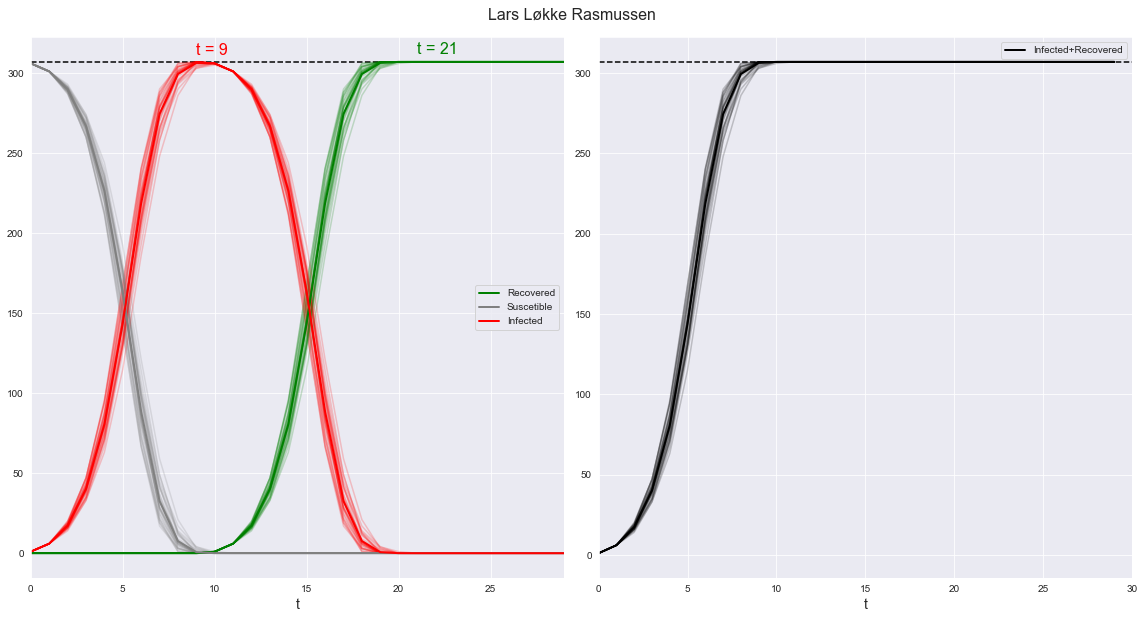

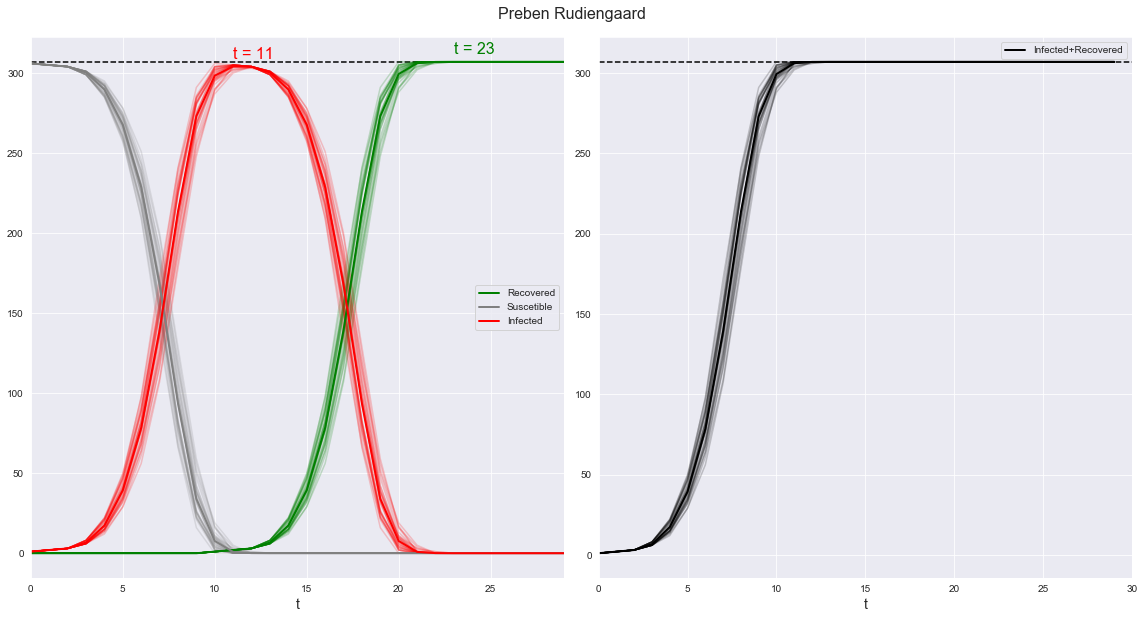

In [111]:
ensembleByNode(FreqDist(deg_c).most_common()[0][0], 30)
plt.savefig("hts_ensemble", bbox_inches="tight", transparent=True)
ensembleByNode(FreqDist(deg_c).most_common()[-1][0], 30)
plt.savefig("preben_ensemble", bbox_inches="tight", transparent=True)
plt.show()

The results derived from the simulations in the GIF's still stands. The difference between the peaks of the infected nodes for the two start nodes is only two iterations and the same goes for the peaks of the recovered nodes. The simulation starting with the least central node has a later increase than its counterpart, which could explain the relatively small difference in iterations. Therefore, it can be reasoned that the number of iterations across different centrality nodes is a fixed difference which depends on the amount of neighbors a node has. 

 # Discussion <a class="anchor" id="22-bullet"></a>

After presenting the tools and result used in this project, a discussion of these will take place. The work with the Twitter dataset carried some limitations, mostly due to only using a developer account with a free membership. This membership only granted permission to download tweets that were up to one week old, meaning that if we wanted to have a significant amount of data, we should have started downloading in the beginning of the semester (or several years ago). This caused the timespan of our two main data sources to be different and the subsequent comparisons were difficult to conduct, since the tweets consists of more recent news or events compared to Wikipedia pages, which gives highlights of several decades. Another limitation with using tweets are that a limited number of Danes uses Twitter relative to Facebook or Instagram. This means that the tweets might not be representable of the broader Danish population to the same degree as other social media platforms. However, since Facebook is notoriously difficult to scrape, it is unlikely that the perfect data for this project can be obtained.

Another data issue occured when the names of all Danish politicians were scraped from danskepolitikere.dk. It was found that the politicians were listed with their full names, which did not correspond to how they were listed on Wikipedia. This meant that the wikipedia pages of some politicians could not be found if the politicians had common or popular names. These names mostly resulted in redirection pages, which were not of interest. As adressed in the sentiment analysis, the name Niels Christian Nielsen both refers to a politician and a criminal who was the main suspect in an ammunition dropping case. Another limitation to using danskepolitikere.dk is the fact that the website was last updated in 2015, which we noticed after we had already scraped the politicians' names, political parties and parliament membership. This meant that the political parties of some politicians might not correspond to their current parties. An example is Uffe Elbæk who is listed as being part of Alternativet in the network, but in reality he has recently created a new party called Frie Grønne.

Despite the above, we still had some succeses while working with the network of Danish politicians. Our code is written to be adaptable to changing input, which means that it is easy to incorporate more data subsequently and thus expand the analysis. We believe that we were not limited by our coding skills, but the issue of time did put us under some constraints as it was not possible for us to go back and extract the politicians' names from another website, or create a network based on Twitter data instead. Even though we had some issues extracting the correct names, the scraping went relatively smooth. The idea of using Twitter data came after the hand-in of project assignment A and we were quite thrilled that we were able to obtain useful data that late in the project phase. The sentiment over time was something which was particularly enjoyable to work with and some interesting results were derived in the analysis. 

A large portion of our time has been spent on creating the website. None of us had previously created a website, which meant that we had plenty of great ideas we could not bring to life. We attempted to the best of our abilities using Wix and we are quite excited about our interactive graphs. Overall, we believe that we have created a website which provides insight to the coverage of Danish politicians on Wikipedia and Twitter in an interesting way.

# Contributions <a class="anchor" id="23-bullet"></a>

The project was created in collaboration between all three students. Below is a table of the main responsible person/persons for all parts of the project. 

| Sections | Subsection/Description | Jesper (s174227) | Ann-Katrine (s184287) | Piriya (s184302)|
|:- --- |: ---| :--- :|:---:|:---:|
| Extraction of Wikipedia data | Using Wikipedia API |x | x | x|
| Extraction of Twitter data | Using Twitter API| x|  | |
| Scaping website for names of politicians | Scraped from danskepolitikere.dk |x | x | x|
| Scaping website for twitter account names of politicians | Scraped from twitterpolitikere.dk |x |  | |
| Descriptive Analysis |In-degree, out-degree distribution and comparison to random network | x| x | |
| Static network visualizations | Looking at the full network and GCC | |  |x |
| Word Clouds| Of individual politicians, parties etc.  |  | |x |
| Sentiment analysis| Of inidvidual politicians, parties ect. and over time |  |x | |
| COVID-19 Simulation| Using SIR-model | x | | |
| Interactive network visualization | Visualization for the website using Gephi |x |  |x |
| Webpage| Setup of the items neatly on the webpage | x| | |
| Webpage| Text on webpage | | x| x|
| Explainer Notebook | Setup of the notebook| | x | |
| Explainer Notebook | Text in notebook | x| x |x |